In [8]:
import numpy as np
from machine import Machine
import random
import torch
from torch import nn
import statistics
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F


#Parameters
lmd0 = 0.013364
lmd1 = 0.333442
lmdM = 1 - lmd0 - lmd1 #0.6531...
mu0 = 0.125
mu1 = 0.25
muM = 0.5
maintenance_cost = 500


#transition matrices

#transition matrix for a = 0 (no maintenance)
a0_tm = np.array([[lmdM, lmd1, 0, 0, 0, 0, 0, 0, 0, lmd0], #current state 0 to next state
                  [0, lmdM, lmd1, 0, 0, 0, 0, 0, 0, lmd0], #current state 1 to next state
                  [0, 0, lmdM, lmd1, 0, 0, 0, 0, 0, lmd0], #current state 2 to next state
                  [0, 0, 0, lmdM, 0, 0, 0, 0, lmd1, lmd0], #current state 3 to next state
                  [muM, 0, 0, 0, 1-muM, 0, 0, 0, 0, 0], #current state 4 to next state
                  [muM, 0, 0, 0, 0, 1-muM, 0, 0, 0, 0], #current state 5 to next state
                  [0, muM, 0, 0, 0, 0, 1-muM, 0, 0, 0], #current state 6 to next state
                  [0, 0, muM, 0, 0, 0, 0, 1-muM, 0, 0], #current state 7 to next state
                  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0], #current state 8 to next state
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]) #current state 9 to next state


#transition matrix for a = 1 (maintenance steps)
a1_tm = np.array([[0, 0, 0, 0, 1-lmd0, 0, 0, 0, 0, lmd0], #current state 0 to next state
                  [0, 0, 0, 0, 0, 1-lmd0, 0, 0, 0, lmd0], #current state 1 to next state
                  [0, 0, 0, 0, 0, 0, 1-lmd0, 0, 0, lmd0], #current state 2 to next state
                  [0, 0, 0, 0, 0, 0, 0, 1-lmd0, 0, lmd0], #current state 3 to next state
                  [muM, 0, 0, 0, 1-muM, 0, 0, 0, 0, 0], #current state 4 to next state
                  [muM, 0, 0, 0, 0, 1-muM, 0, 0, 0, 0], #current state 5 to next state
                  [0, muM, 0, 0, 0, 0, 1-muM, 0, 0, 0], #current state 6 to next state
                  [0, 0, muM, 0, 0, 0, 0, 1-muM, 0, 0], #current state 7 to next state
                  [mu1, 0, 0, 0, 0, 0, 0, 0, 1-mu1, 0], #current state 8 to next state
                  [mu0, 0, 0, 0, 0, 0, 0, 0, 0, 1-mu0]]) #current state 9 to next state
tm = [a0_tm,a1_tm]
#r_func = {0:2000,1:1500,2:1000,3:500,4:-maintenance_cost,5:-maintenance_cost,6:-maintenance_cost,7:-maintenance_cost,8:-3000,9:-2000}
r_func = {0:1000,1:900,2:800,3:500,4:-500,5:-500,6:-500,7:-500,8:-3000,9:-1000}

class Machine_env():
    '''
    Description:
    Code creates an environment for the policy to interact with the simulated machine.

    States:
    The simulated machine has 10 states
    [0,1,2,3] are working states that degrades as the state number increases.
    [4,5,6,7] are maintenance states that are transited from [0,1,2,3] respectively if the action deems it need transition
    [8,9] are failure state, where 8 is sudden failure state that can occur from [0,1,2,3] while 9 is a degraded failure from 3

    Actions:
    Type: Discrete(2)
    Num
    0: No maintenance
    1: Maintenance

    Rewards:
    reward_func = {0:1000,1:900,2:900,3:500,4:-500,5:-500,6:-500,7:-500,8:-3000,9:-1000}

    Observations:
    Produced using MachineSensor class that uses gmm from pickle file

    Episode:
    Since it is continous Markov model, we shall set 1 episode is 20 steps


    Pseudo code

    initialise class
    Loop 20 times: #1 episode
        sensor()
        action()
        step()

    final otp: Class that contains rewards,actions, observations --> will be used to improve policy (ie. optimise theta)
        
''' 

    def __init__(self,tm,r_func):
        self.action_space = [0,1]
        self.state = 0 #Random initialise the start state, assumes uniform distribution for initial state,random.randrange(10)
        self.state_seq = [] #initialise a list that records the actual states
        self.reward_func = r_func
        self.observation_space = 4
        self.transition  = tm
        self.simulator = Machine() #simulator to generate sensor readings
        self.steps = 0
    
    def sensor(self,state): # generate observation at state
        self.simulator.curr_state = state
        sensor_reading = self.simulator.readSensors()
        return sensor_reading
    
    def step(self,action): # simulate movement of states given an action
        
        self.state_seq.append(self.state) #record current state
        
        transition_mat_action = self.transition[action]
        #print(f"Transition Prob: {transition_mat_action[self.state]}")
        nxt_state = np.random.choice([i for i in range(10)],1,p=transition_mat_action[self.state])[0] #select nxt state based

        
        reward = self.reward_func[nxt_state] #reward for going to next state
        self.steps += 1
        self.state = nxt_state #update state

        return reward
    
    def reset(self):
        self.state = 0
        self.done = False
        self.steps = 0
        self.state_seq = []
        return 
        


In [9]:
class policy_estimator(nn.Module): #neural network
    def __init__(self, env):
        super(policy_estimator, self).__init__()
        
        self.lstm = nn.LSTMCell(env.observation_space,128)
        self.layer1 = nn.Linear(128,128)
        
        self.layer2 = nn.Linear(128,len(env.action_space))
       
            
    
    def forward(self, x):#prediction is raw value
        x = torch.FloatTensor(x)
        output = []
        hx = torch.zeros(1,128)
        cx = torch.zeros(1,128)
        
        if(len(x.size()) == 1): #single tensor ie. [x1,x2,x3,x4]
            x = x.unsqueeze(0)
            #print(x)
            hx, cx = self.lstm(x, (hx, cx))
            output = hx
            #print(output)

        elif(len(x.size()) == 2): #2 dimension
            x = x.unsqueeze(1) #dim = (timestep,batch,features), note batch = 1
#             print(x.size())
            for i in range(x.size()[0]): #loop to simulate recurrent network
                #print(y)
                hx, cx = self.lstm(x[i], (hx, cx))
                output.append(hx)
        
            output = torch.stack(output, dim=0).squeeze(1) #convert to tensor
        
        x = F.leaky_relu(output)
        x = self.layer1(x)
        x  = F.relu(x)
        x = self.layer2(x)

        return F.softmax(x,dim = -1)



In [10]:
def normalized_discount_reward(rewards,gamma):
    r = np.array([gamma**i * rewards[i] 
        for i in range(len(rewards))])
    # Reverse the array direction for cumsum and then
    # revert back to the original order
    r = r[::-1].cumsum()[::-1]
    r = np.array(r)
    mean_rewards=np.mean(r)
    std_rewards=np.std(r)
    norm_discounted_rewards=(r-mean_rewards)/(std_rewards+1e-12)
    return norm_discounted_rewards.tolist()

class StateValueNetwork(nn.Module):
    
    #Takes in state
    def __init__(self, observation_space):
        super(StateValueNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.lstm = nn.LSTMCell(observation_space,128)
        self.layer1 = nn.Linear(128, 128)
        self.layer2 = nn.Linear(128, 1)
        
    def forward(self, x):
        #input layer
        x = torch.FloatTensor(x)
        output = []
        hx = torch.zeros(1,128)
        cx = torch.zeros(1,128)
        
        if(len(x.size()) == 1): #single tensor ie. [x1,x2,x3,x4]
            x = x.unsqueeze(0)
            #print(x)
            hx, cx = self.lstm(x, (hx, cx))
            output = hx
            #print(output)

        elif(len(x.size()) == 2): #2 dimension
            x = x.unsqueeze(1) #dim = (timestep,batch,features), note batch = 1
#             print(x.size())
            for i in range(x.size()[0]): #loop to simulate recurrent network
                #print(y)
                hx, cx = self.lstm(x[i], (hx, cx))
                output.append(hx)
        
            output = torch.stack(output, dim=0).squeeze(1) #convert to tensor
        
        x = F.leaky_relu(output)
        x = self.layer1(x)
        x  = F.relu(x)
        x = self.layer2(x)
        state_value = x
        
        return state_value
    
def train_value(G, state_vals, optimizer):
    ''' Update state-value network parameters
    Args:
    - G (Array): trajectory of cumulative discounted rewards 
    - state_vals (Array): trajectory of predicted state-value at each step
    - optimizer (Pytorch optimizer): optimizer to update state-value network parameters
    '''
    
    G = G.to(torch.float32)
    state_vals = state_vals.to(torch.float32)
    #calculate MSE loss
    val_loss = F.mse_loss(state_vals, G)
        
    #Backpropagate
    optimizer.zero_grad()
    val_loss.backward()
    optimizer.step()
    

def stack_state_value(states,stateval_network): #input is a list of observations/states that will be used to train the nn for statevalue network
    state_vals = []
    for state in states:
        state = torch.from_numpy(state).float().unsqueeze(0)
        state_vals.append(stateval_network(state))
    return torch.stack(state_vals).squeeze()

In [ ]:
import paho.mqtt.client as mqtt
def on_connect(self, client, userdata, flags, rc):
    if rc == 0:
        print('Connected OK')
    else:
        print('Bad connection Returned code = ' + str(rc))

def on_disconnect(self, client, userdata, flags, rc = 0):
    print('Disconnected result code: ' + str(rc))

def on_message(self, client, userdata, message):
    message_topic = message.topic
    message_payload = message.payload.decode('utf-8')
    print('Message topic: ' + message.topic)
    print('Message received: ' + message_payload)
    print('\n')

Additional Improvement:
- Recurrent implementation --> action taken by referencing 10 frames behind
- Model does not learn about the maintenance readings = [-1,-1,-1,-1] default action for these states are no action, cost of maintenance is cumulative depending on how long it stays in the maintenance state
- Add batch size which will determine the update frequency of the policy during simulation
- longer episodic update of policy but more of batch update
- Every batch update the input internal states to the next batch is updated


# Non Episodic/Batch update

In [18]:
def recurrent_pg_baseline(machine,baseline_net,policy_estimator,timesteps,lookback,gamma,lr): #Learning algo
    # Set up lists to hold results
    # Set up lists to hold results
    total_rewards = [] #Total actual reward for each episode
    batch_rewards = []  #Discounted expected future rewards for each batch
    batch_actions = []
    batch_observation = []
    state_seq = []
    counter = 0

    
    # Define optimizer
    optimizer = torch.optim.Adam(policy_estimator.parameters(),lr=lr)
    state_val_optimizer = torch.optim.Adam(baseline_net.parameters(),lr=0.001)
    
    action_space = machine.action_space
    
    machine.reset()
    observation = []
    rewards = []
    actions = []
    batch_obs = []
    t = 0
    
    for t in range(timesteps):
        
        obs = machine.sensor(machine.state).tolist() #observation
        
        batch_obs.append(obs)
        
        if len(observation) < lookback:
            action_probs = policy_estimator(batch_obs).detach().numpy()[-1] #convert to numpy and get action prob for the latest
        else:
            print(action_probs)
            action_probs = policy_estimator(batch_obs[-lookback:]).detach().numpy()[-1]
        
        try:
            action = np.random.choice(action_space, p=action_probs) #select weighted actions based on NN output prob
        except: #in the event converged
            action_probs = np.nan_to_num(action_probs)
            action_probs = np.round(action_probs)
            action = np.random.choice(action_space, p=action_probs)
            
        print(f"Sensor: {obs}, Action prob: {action_probs}, Action: {action}, state: {machine.state}")
        
        r = machine.step(action) #receive reward and update machine to the next state after doing the sampled action
        
        rewards.append(r)
        actions.append(action)
        
        while(r == -maintenance_cost): #cumulate maintenance
            r = machine.step(0)
            rewards[-1] += r 
            print(f"Maintenance in progress, cumulative {rewards[-1]}")
        
        counter+=1
        

        if(not counter%lookback): #batch update policy
            observation.extend(batch_obs)
            discount_r = normalized_discount_reward(rewards[-lookback:],gamma) #normalised future rewards

            obs_tensor = torch.FloatTensor(observation[-lookback:])
            action_tensor = torch.LongTensor(actions[-lookback:])
            reward_tensor = torch.from_numpy(np.array(discount_r).copy()) #discounted reward G

            #calculate state values 
            state_value_tensor = stack_state_value(np.array(observation[-lookback:]),baseline_net)

            #train state value network
#             print(rewards)
#             print(reward_tensor,state_value_tensor)
            train_value(reward_tensor,state_value_tensor,state_val_optimizer)

            #calculate delta or advantage 
            deltas = [gt - val for gt, val in zip(reward_tensor, state_value_tensor)]
            deltas = torch.tensor(deltas)



            logprob = torch.log(policy_estimator(obs_tensor))

            #print(logprob[np.arange(len(action_tensor)), action_tensor])
            selected_logprobs = deltas * logprob[np.arange(len(action_tensor)), action_tensor]
            print(selected_logprobs)


            loss = -selected_logprobs.mean()
            
            if loss != 0:
                optimizer.zero_grad()
                # Calculate gradients
                loss.backward()
                # Apply gradients
                optimizer.step()
            
            batch_obs = [] #reset batch
            total_rewards.append(sum(rewards)) #Cumulative reward for this batch
            print(f"Reward for up to this timestep {t+1} is {total_rewards[-1]}, loss is {loss}")
            continue
            
        total_rewards.append(sum(rewards))
        
        
        
#         #Tensorboard params
#         writer.add_scalar("Loss", loss, ep)
#         writer.add_scalar('Rewards',sum(rewards),ep)
#         for name, weight in policy_estimator.network.named_parameters():
#             try:
#                 writer.add_histogram(name,weight, ep)
#             except:
#                 continue
#             if weight.grad != None:
#                 writer.add_histogram(f"{name}.grad",weight.grad, ep)
    
#     writer.add_graph(policy_estimator.network,torch.FloatTensor(machine.sensor(0))) #draw graph
#     writer.flush()
#     writer.close()
    
    return (total_rewards,batch_actions,state_seq)

C:\Users\overl\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.20.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


{0: 1000, 1: 900, 2: 800, 3: 500, 4: -500, 5: -500, 6: -500, 7: -500, 8: -3000, 9: -1000}
Sensor: [0.337017098974057, 0.6858265145652863, 0.1640811890730791, 0.2644662983074236], Action prob: [0.49339536 0.5066047 ], Action: 1, state: 0
Maintenance in progress, cumulative 500
Sensor: [0.37571670033791515, 0.668710069865872, 0.22827647210316343, 0.2782638038435191], Action prob: [0.49381194 0.50618804], Action: 0, state: 0
Sensor: [0.4085559838771688, 0.6331438081732886, 0.21302601248983893, 0.28200092293748147], Action prob: [0.4939201 0.5060799], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
Sensor: [0.39874490435572785, 0.6413672670365032, 0.23766281705685044, 0.25207299972968383], Action prob: [0.49391305 0.50608695], Action: 1, state: 0
Maintenance in progress, cumulative 500
Sensor: [0.3809323423191324, 0.6556843543662995, 0.22049672991203564, 0.46154232712554455], Action prob: [0.49371082 0.50628924], Action: 1, state: 0
Maint

Sensor: [0.3231261707133339, 0.6492714509525741, 0.17973349606439631, 0.2553899419280064], Action prob: [0.59494317 0.4050569 ], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
[0.59494317 0.4050569 ]
Sensor: [0.3550194592336608, 0.6335230037711411, 0.19296378872827386, 0.2504408972924345], Action prob: [0.60776824 0.39223173], Action: 0, state: 0
[0.60776824 0.39223173]
Sensor: [0.3127083322403479, 0.56252862315046, 0.23109796653995518, 0.27722228447616076], Action prob: [0.6149891  0.38501093], Action: 0, state: 0
[0.6149891  0.38501093]
Sensor: [0.353332073420058, 0.6742890065427126, 0.229339424570223, 0.2640225494662667], Action prob: [0.6201771 0.379823 ], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -1500
Maintenance in progress, cumulative -500
[0.6201771 0.379823 ]
Sensor: [0.43340594179709885, 0.6581177998043718, 0.4419282862856742, 0.2792990982082168], Action prob: [0.6240

Reward for up to this timestep 80 is 40900, loss is 0.05591510853179378
[0.6518277  0.34817234]
Sensor: [0.34970567677438313, 0.636879111123194, 0.24394873208595522, 0.20393947680512922], Action prob: [0.5888871 0.411113 ], Action: 0, state: 1
[0.5888871 0.411113 ]
Sensor: [0.42108138844184295, 0.6349104922707628, 0.2112665564669464, 0.28078192401777247], Action prob: [0.6130815 0.3869185], Action: 1, state: 1
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -1500
Maintenance in progress, cumulative -500
[0.6130815 0.3869185]
Sensor: [0.3537789496461373, 0.6435495930783518, 0.2475214057447564, 0.24774586264071718], Action prob: [0.6262478  0.37375215], Action: 0, state: 0
[0.6262478  0.37375215]
Sensor: [0.41452505042849763, 0.6980432021208418, 0.18958780770948333, 0.23054669882933557], Action prob: [0.6330998 0.3669002], Action: 0, state: 1
[0.6330998 0.3669002]
Sensor: [0.39123801491372484, 0.6146592154275446, 0.2097862697847746, 0.26495912944932987], Act

       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 128 is 36700, loss is 0.08737066894383427
[0.57770044 0.42229953]
Sensor: [0.3860397351597426, 0.3600706137472293, 0.19811112616925222, 0.2859649651069718], Action prob: [0.55999225 0.44000775], Action: 0, state: 8
[0.55999225 0.44000775]
Sensor: [0.37343527875742816, 0.6074870843164075, 0.2131645903756971, 0.5709017822473268], Action prob: [0.56867576 0.43132424], Action: 0, state: 8
[0.56867576 0.43132424]
Sensor: [0.301274034715418, 0.6939109656216194, 0.20350553611787606, 0.5755423168551563], Action prob: [0.5700359 0.4299641], Action: 0, state: 8
[0.5700359 0.4299641]
Sensor: [0.36157400613254836, 0.40897757228693804, 0.24585158248771724, 0.25247794982385646], Action prob: [0.5669479 0.4330522], Action: 1, state: 8
[0.5669479 0.4330522]
Sensor: [0.34312883673431677, 0.6420777798147085, 0.24840418234977735, 0.24017140518152894], Action prob: [0.5659103  0.43408972], Action: 0, state: 0
[0.5659103  0.

Sensor: [0.34914512928940294, 0.611004930613332, 0.18815037381250374, 0.26161133013901217], Action prob: [0.5390652  0.46093476], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -1500
Maintenance in progress, cumulative -500
[0.5390652  0.46093476]
Sensor: [0.39801692791541676, 0.6009537614289188, 0.20715637047116667, 0.25090965625909734], Action prob: [0.5390562 0.4609438], Action: 0, state: 0
tensor([-1.4180, -0.7921, -0.2386,  0.2723,  0.2155,  0.7870,  0.7870,  0.4606],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 184 is 51300, loss is -0.009221491291166388
[0.5390562 0.4609438]
Sensor: [0.34511287928387563, 0.6863467611442825, 0.20892992445179534, 0.2481668786480508], Action prob: [0.5420007  0.45799932], Action: 0, state: 1
[0.5420007  0.45799932]
Sensor: [0.3505355631504929, 0.6464968452412087, 0.18659177819004366, 0.2674423918970162], Action prob: [0.5436087  0.45639122], Action: 0, state: 1

[0.5405793 0.4594207]
Sensor: [0.3489919693817099, 0.6528504831435243, 0.22877261735325194, 0.5395211238894434], Action prob: [0.54248893 0.45751113], Action: 0, state: 0
[0.54248893 0.45751113]
Sensor: [0.3192999068328893, 0.43156347494144753, 0.2171497064078023, 0.2598180209078446], Action prob: [0.5436518 0.4563482], Action: 1, state: 0
Maintenance in progress, cumulative 500
[0.5436518 0.4563482]
Sensor: [0.35182449516183883, 0.6415180243864596, 0.2032665133054145, 0.20152262690490988], Action prob: [0.5429026  0.45709738], Action: 0, state: 0
[0.5429026  0.45709738]
Sensor: [0.3004879563655665, 0.620526326186586, 0.27887724993050106, 0.2426469281099668], Action prob: [0.54164255 0.45835742], Action: 1, state: 0
Maintenance in progress, cumulative 500
[0.54164255 0.45835742]
Sensor: [0.37045076243312836, 0.6376983491248466, 0.21083567154101718, 0.27253973821749594], Action prob: [0.54102606 0.458974  ], Action: 0, state: 0
[0.54102606 0.458974  ]
Sensor: [0.36076691496930396, 0.677

Reward for up to this timestep 272 is 16300, loss is -0.016239095700458686
[0.53675985 0.46324015]
Sensor: [0.3479498782815484, 0.6389725484470499, 0.22984994375383921, 0.2501108224926389], Action prob: [0.536931 0.463069], Action: 0, state: 1
[0.536931 0.463069]
Sensor: [0.2961368541380089, 0.6218688114852473, 0.20863662211548242, 0.2099632233880842], Action prob: [0.5389411 0.4610589], Action: 0, state: 2
[0.5389411 0.4610589]
Sensor: [0.37151747957906955, 0.5474045266175748, 0.1982135801872625, 0.25352806652652543], Action prob: [0.5382565  0.46174347], Action: 0, state: 2
[0.5382565  0.46174347]
Sensor: [0.3071884222562707, 0.5940085459508179, 0.23403106276663324, 0.2334185711556715], Action prob: [0.5375123  0.46248767], Action: 0, state: 2
[0.5375123  0.46248767]
Sensor: [0.35846418638582, 0.658874827688315, 0.17769094066087765, 0.25010522703403704], Action prob: [0.53716874 0.46283123], Action: 0, state: 2
[0.53716874 0.46283123]
Sensor: [0.35537503807525755, 0.5818871843890632,

Sensor: [0.304178010021325, 0.6770599837814617, 0.19936476194637784, 0.266527730692558], Action prob: [0.5269598  0.47304028], Action: 1, state: 0
Maintenance in progress, cumulative 500
[0.5269598  0.47304028]
Sensor: [0.36952268827241225, 0.6520850538233164, 0.21947728327584487, 0.2002713317097144], Action prob: [0.5269155  0.47308457], Action: 0, state: 0
tensor([-1.1341, -0.9538, -0.3725,  0.1222,  0.3988,  0.6519,  0.6529,  0.7322],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 312 is 39500, loss is -0.0121955158544753
[0.5269155  0.47308457]
Sensor: [0.3734979985939492, 0.640922335667209, 0.237941523402767, 0.24583902124037185], Action prob: [0.5265405  0.47345942], Action: 0, state: 0
[0.5265405  0.47345942]
Sensor: [0.38636787705538933, 0.6974409766189084, 0.24599268884314596, 0.2783887899838496], Action prob: [0.5270465  0.47295353], Action: 0, state: 1
[0.5270465  0.47295353]
Sensor: [0.3146514296741266, 0.620282317204909, 0.21254685943969

Reward for up to this timestep 352 is 55500, loss is -0.02145991805107638
[0.51800245 0.48199752]
Sensor: [0.3783254525076366, 0.726149605845133, 0.22044448490160273, 0.29944572067074077], Action prob: [0.52362835 0.4763717 ], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
[0.52362835 0.4763717 ]
Sensor: [0.40911574576951526, 0.5974581885653486, 0.24243230016781395, 0.23700518417699257], Action prob: [0.523569   0.47643104], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -1500
Maintenance in progress, cumulative -2000
Maintenance in progress, cumulative -2500
Maintenance in progress, cumulative -3000
Maintenance in progress, cumulative -3500
Maintenance in progress, cumulative -4000
Maintenance in progress, cumulative -3000
[0.523569   0.47643104]
Sensor: [0.35573003240394174, 0.6618656988478464, 0.15005624781930027, 0.2656860094701952], Action prob: [0.52222383 0.47777617], Action: 

[0.5367127  0.46328723]
Sensor: [0.4650740372683268, 0.626297908456814, 0.20165974108787338, 0.2213601257702007], Action prob: [0.536544   0.46345595], Action: 0, state: 1
tensor([-0.9992, -0.8011, -0.4946, -0.1931,  0.1358,  0.4360,  0.7021,  0.9434],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 392 is 74000, loss is 0.03384132793314269
[0.536544   0.46345595]
Sensor: [0.35860251230097284, 0.6265992552323704, 0.19039658099443868, 0.28336296200159133], Action prob: [0.53922117 0.46077874], Action: 0, state: 2
[0.53922117 0.46077874]
Sensor: [0.34571405071782246, 0.6669628088018693, 0.2369640416821481, 0.23263658960124192], Action prob: [0.54118294 0.45881706], Action: 1, state: 3
Maintenance in progress, cumulative 300
[0.54118294 0.45881706]
Sensor: [0.33494290315681247, 0.6050300157189987, 0.23884028459063852, 0.24324851064324832], Action prob: [0.5404849  0.45951504], Action: 1, state: 2
Maintenance in progress, cumulative 400
[0.5404849  0.4595

Sensor: [0.4274309448363666, 0.6333084785171834, 0.19652382069538074, 0.2227204082565526], Action prob: [0.5428612 0.4571387], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
[0.5428612 0.4571387]
Sensor: [0.32508523264067746, 0.6303843844427869, 0.1994158725010088, 0.2408603301916351], Action prob: [0.54287875 0.45712125], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
tensor([-1.1234, -0.6527, -0.2833,  0.0664,  0.2016,  0.6554,  0.8501,  0.8530],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 432 is 49000, loss is -0.07087244844552072
[0.54287875 0.45712125]
Sensor: [0.3977741187815285, 0.5914951985308328, 0.24709764903977657, 0.5254123463302116], Action prob: [0.54969865 0.4503013 ], Action: 0, state: 0
[0.54969865 0.4503013 ]
Sensor: [0.3782606564609678, 0.5852236136917406, 0.19885212478997996, 0.28460712023117357], Action prob: [0.55166763 0

Sensor: [0.3442641987255054, 0.6324171796962579, 0.19937953433898467, 0.22473724196193867], Action prob: [0.5714544  0.42854553], Action: 1, state: 0
Maintenance in progress, cumulative 500
[0.5714544  0.42854553]
Sensor: [0.3724505863405753, 0.6680234031166068, 0.20859313639084942, 0.22617469002077328], Action prob: [0.5715161  0.42848387], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -1500
Maintenance in progress, cumulative -2000
Maintenance in progress, cumulative -1000
[0.5715161  0.42848387]
Sensor: [0.3284166545677976, 0.6429023447133648, 0.21492074779753628, 0.2757428516299399], Action prob: [0.5716151  0.42838493], Action: 0, state: 0
tensor([-1.2827, -0.8433, -0.2396,  0.4745,  0.0629,  0.7739,  1.0787,  0.3501],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 472 is 58000, loss is -0.04680086818978426
[0.5716151  0.42838493]
Sensor: [0.37740850426357503, 0.3296363448447999, 0.242216839012

[0.59544814 0.4045519 ]
Sensor: [0.3178533710664275, 0.6060621955808168, 0.24777263566154226, 0.25439132653394037], Action prob: [0.5945572 0.4054427], Action: 0, state: 0
[0.5945572 0.4054427]
Sensor: [0.349471660517328, 0.5746771563993046, 0.2203957046660492, 0.21358286629376738], Action prob: [0.59375733 0.40624264], Action: 0, state: 0
[0.59375733 0.40624264]
Sensor: [0.3518126335395816, 0.6494970532239457, 0.19565688573566006, 0.2508347915391195], Action prob: [0.593922   0.40607798], Action: 1, state: 0
Maintenance in progress, cumulative 500
[0.593922   0.40607798]
Sensor: [0.32789232128658863, 0.6897783956059418, 0.23354919160858417, 0.23512706269515218], Action prob: [0.5942609  0.40573916], Action: 1, state: 0
Maintenance in progress, cumulative 500
tensor([-0.8203, -0.8000, -0.4553, -0.1439,  0.1373,  0.3906,  1.0715,  1.2535],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 512 is 80000, loss is -0.07916921831438992
[0.5942609  0.40573916]

Reward for up to this timestep 552 is 16300, loss is 0.002985559552093009
[0.63067186 0.3693281 ]
Sensor: [0.34286291136934277, 0.3141029193378079, 0.18063410068107347, 0.24204095567070713], Action prob: [0.617845   0.38215503], Action: 1, state: 8
[0.617845   0.38215503]
Sensor: [0.42238386534959227, 0.7005827575726407, 0.18225767625033706, 0.5555371884056932], Action prob: [0.63392085 0.36607915], Action: 0, state: 8
[0.63392085 0.36607915]
Sensor: [0.5548901246152558, 0.6697132356038975, 0.2160336206922892, 0.22781739808088536], Action prob: [0.6368388 0.3631612], Action: 0, state: 8
[0.6368388 0.3631612]
Sensor: [0.33998131924316805, 0.4161566432524123, 0.23655000096382606, 0.23506478059046496], Action prob: [0.6348113 0.3651888], Action: 0, state: 8
[0.6348113 0.3651888]
Sensor: [0.34647333623039084, 0.3793556402113556, 0.23351607691582954, 0.23064417965510492], Action prob: [0.6334004  0.36659965], Action: 1, state: 8
[0.6334004  0.36659965]
Sensor: [0.32050413563370905, 0.618532

tensor([-0.9276, -1.4219, -0.4006, -0.2630,  0.0299,  0.2757,  0.4940,  0.6924],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 592 is 28000, loss is 0.19012450797486047
[0.6530887  0.34691128]
Sensor: [0.35238122620173273, 0.6454068217431543, 0.23285795824874367, 0.2903762193255415], Action prob: [0.635317 0.364683], Action: 0, state: 0
[0.635317 0.364683]
Sensor: [0.38932730535414295, 0.6184039781767225, 0.2184735253727079, 0.24943039124211502], Action prob: [0.6456071 0.3543929], Action: 0, state: 0
[0.6456071 0.3543929]
Sensor: [0.37985690654142085, 0.6850695100766199, 0.19593842291358377, 0.26344641881713765], Action prob: [0.6470208  0.35297918], Action: 1, state: 1
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -1500
Maintenance in progress, cumulative -2000
Maintenance in progress, cumulative -2500
Maintenance in progress, cumulative -1500
[0.6470208  0.35297918]
Sensor: [0.3252915550128483, 0.63902131039882, 0.

Sensor: [0.600771897147124, 0.36602008406237774, 0.2259074183061433, 0.22893203428872455], Action prob: [0.6253538 0.3746462], Action: 0, state: 9
[0.6253538 0.3746462]
Sensor: [0.3690133405229088, 0.4346234464679703, 0.22315883454750088, 0.2240562785757302], Action prob: [0.6227868  0.37721324], Action: 1, state: 9
[0.6227868  0.37721324]
Sensor: [0.36483764056592594, 0.3602320500349822, 0.3713061785896342, 0.2308413463000288], Action prob: [0.6221947  0.37780523], Action: 0, state: 9
[0.6221947  0.37780523]
Sensor: [0.35633761778814266, 0.3482145146771758, 0.2421661151224898, 0.20763585371206533], Action prob: [0.62172264 0.3782773 ], Action: 0, state: 9
tensor([ 0.7524,  0.4819,  0.2529,  0.1080, -0.1640, -0.7034, -0.5054, -0.6559],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 640 is 30200, loss is 0.054184311211989286
[0.62172264 0.3782773 ]
Sensor: [0.5784116117746699, 0.6467170789568362, 0.515703438082011, 0.25992103756456514], Action prob: [

       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 680 is 32600, loss is -0.10152958449916599
[0.59306264 0.40693736]
Sensor: [0.3558171288330013, 0.6068898451026712, 0.20271692289616952, 0.34289737864075476], Action prob: [0.63187987 0.36812016], Action: 1, state: 1
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
[0.63187987 0.36812016]
Sensor: [0.3213148070457844, 0.6490013128703838, 0.21936487953150272, 0.25405328418548817], Action prob: [0.62801343 0.3719865 ], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
[0.62801343 0.3719865 ]
Sensor: [0.34361547827552197, 0.6541492112869278, 0.2021065080646354, 0.22679371642163487], Action prob: [0.6166025  0.38339755], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -1500
Maintenance in progress, cumulative -500
[0.6166025  0.38339755]
Sensor: [0.3809902511707924, 0.626098093300

Sensor: [0.3087368460402295, 0.6557255021149, 0.24518150855420048, 0.22867708799835676], Action prob: [0.59306633 0.40693372], Action: 1, state: 3
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -200
[0.59306633 0.40693372]
Sensor: [0.3333376715338464, 0.559655290513648, 0.2222221294937384, 0.2341924757438315], Action prob: [0.59002763 0.40997234], Action: 0, state: 2
[0.59002763 0.40997234]
Sensor: [0.3569865051914406, 0.6071433271872281, 0.16759231491466986, 0.22815167512603235], Action prob: [0.58844554 0.41155446], Action: 1, state: 3
Maintenance in progress, cumulative 300
tensor([-0.9065, -0.5306, -0.2199,  0.0779,  0.3231,  0.8074,  0.4208,  0.8986],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 728 is 53700, loss is -0.10885624390096948
[0.58844554 0.41155446]
Sensor: [0.3951531595571332, 0.6351549095799872, 0.21116172314940243, 0.25743827498094024], Action prob: [0.6296851  0.37031496], Action: 0, state: 2
[0.6

[0.63729656 0.3627034 ]
Sensor: [0.2742150122139651, 0.4500061723759716, 0.21184415271236137, 0.21305753619892415], Action prob: [0.6344468 0.3655532], Action: 0, state: 2
[0.6344468 0.3655532]
Sensor: [0.444097824022098, 0.5807215804556973, 0.19722113496109792, 0.3817371226107325], Action prob: [0.63319594 0.36680397], Action: 1, state: 2
Maintenance in progress, cumulative 400
[0.63319594 0.36680397]
Sensor: [0.36458917626182813, 0.6246931109404641, 0.24020088093142908, 0.30893764357207], Action prob: [0.63232464 0.36767545], Action: 0, state: 1
[0.63232464 0.36767545]
Sensor: [0.3729449545432062, 0.6427997916544654, 0.21838451282171098, 0.24048020958668312], Action prob: [0.631596   0.36840397], Action: 0, state: 1
[0.631596   0.36840397]
Sensor: [0.3475674163887271, 0.5714131369561861, 0.21247056639632203, 0.2537009997217373], Action prob: [0.63103485 0.36896518], Action: 1, state: 2
Maintenance in progress, cumulative 400
tensor([-1.3974, -0.6133, -0.3029, -0.0508,  0.3870,  0.283

Sensor: [0.4103543872345816, 0.6302520751135758, 0.24345202340200178, 0.23969309319884968], Action prob: [0.6347586 0.3652414], Action: 1, state: 2
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -100
[0.6347586 0.3652414]
Sensor: [0.3078908210863124, 0.5802874028086594, 0.22632713552843522, 0.28600406055510785], Action prob: [0.6340909 0.3659091], Action: 0, state: 1
[0.6340909 0.3659091]
Sensor: [0.3665183879793642, 0.5670878357687046, 0.2251780162045993, 0.2701606640492606], Action prob: [0.63329405 0.36670598], Action: 0, state: 1
[0.63329405 0.36670598]
Sensor: [0.3275799054316505, 0.6157232289545129, 0.27220828688752, 0.22947327827479186], Action prob: [0.6329352  0.36706477], Action: 0, state: 1
[0.6329352  0.36706477]
Sensor: [0.3855838069848314, 0.6727049377995441, 0.21023614132039997, 0.23408177584874565], Action prob: [0.63282233 0.36717772], Action: 0, state: 1
[0.63282233 0.36717772]
Sensor: [0.3626622484183592, 0.6514356224861241, 0.200840992

Sensor: [0.29614058335077476, 0.6126910387451178, 0.23163442849221078, 0.26510635558335993], Action prob: [0.61321473 0.38678527], Action: 1, state: 0
Maintenance in progress, cumulative 500
[0.61321473 0.38678527]
Sensor: [0.323290107078998, 0.6264563638109732, 0.19422275455567037, 0.28995168413871397], Action prob: [0.61249334 0.38750666], Action: 0, state: 0
[0.61249334 0.38750666]
Sensor: [0.3823071220323162, 0.6595220667932875, 0.19326201580429542, 0.24057911025241815], Action prob: [0.61203605 0.38796398], Action: 0, state: 0
[0.61203605 0.38796398]
Sensor: [0.3347540806404188, 0.6272887024681688, 0.4407942769504152, 0.5297024199640505], Action prob: [0.6115542  0.38844576], Action: 0, state: 1
[0.6115542  0.38844576]
Sensor: [0.38063044030813953, 0.6165349742020071, 0.2890583937065348, 0.297491343709653], Action prob: [0.61119336 0.3888066 ], Action: 0, state: 1
tensor([-1.2415, -0.6230, -0.3716, -0.3708, -0.0148,  0.3041,  0.5743,  0.8026],
       dtype=torch.float64, grad_fn=<

[0.591069   0.40893108]
Sensor: [0.28010469108322655, 0.6479847795624807, 0.21219020449164952, 0.26067690534195054], Action prob: [0.5906209 0.4093791], Action: 0, state: 0
[0.5906209 0.4093791]
Sensor: [0.37322346815456586, 0.5823040441849187, 0.19958825766327368, 0.4147518460945452], Action prob: [0.58985484 0.4101452 ], Action: 0, state: 0
[0.58985484 0.4101452 ]
Sensor: [0.3680874070874936, 0.5774271182127939, 0.25548681447301747, 0.231365012936027], Action prob: [0.58956933 0.41043073], Action: 0, state: 0
tensor([-1.7532, -0.8489, -0.2531,  0.2113,  0.5352,  0.1455,  0.4544,  0.7338],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 904 is 48200, loss is 0.09687460894157363
[0.58956933 0.41043073]
Sensor: [0.32936901722764445, 0.6744047222425786, 0.21677801644700445, 0.26624008207714145], Action prob: [0.592695 0.407305], Action: 0, state: 0
[0.592695 0.407305]
Sensor: [0.3696137897269912, 0.623944320076917, 0.17317476454546799, 0.271386001500378

[0.57013136 0.4298687 ]
Sensor: [0.3286117231656497, 0.6435302655119842, 0.2113554333187416, 0.2519485421239435], Action prob: [0.56955117 0.4304488 ], Action: 1, state: 1
Maintenance in progress, cumulative 500
[0.56955117 0.4304488 ]
Sensor: [0.3320023857833931, 0.6213643644163332, 0.20665683989588118, 0.27574986014875513], Action prob: [0.56917036 0.43082967], Action: 0, state: 0
[0.56917036 0.43082967]
Sensor: [0.30680829313213626, 0.6903988894192306, 0.2314377710701138, 0.2536251425479672], Action prob: [0.56898016 0.43101987], Action: 0, state: 0
tensor([-0.8887, -0.7332, -0.4707, -0.1136,  0.1681,  0.6598,  0.5733,  0.8128],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 944 is 73700, loss is -0.0009800903925014093
[0.56898016 0.43101987]
Sensor: [0.31886494907663965, 0.6934870037204235, 0.21991721169643305, 0.2689337613315653], Action prob: [0.58132434 0.4186756 ], Action: 0, state: 1
[0.58132434 0.4186756 ]
Sensor: [0.29737737645242895, 0.59

Sensor: [0.3258518965544966, 0.6635893180576874, 0.20283321777969476, 0.23368990080568325], Action prob: [0.5583642  0.44163585], Action: 1, state: 1
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
[0.5583642  0.44163585]
Sensor: [0.4058814611533458, 0.6559454958075083, 0.1913123521276413, 0.19056658157595424], Action prob: [0.55717224 0.44282776], Action: 0, state: 0
[0.55717224 0.44282776]
Sensor: [0.3706098801988, 0.6422401583337548, 0.2072821726806383, 0.2694425961080531], Action prob: [0.55614257 0.44385734], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -1500
Maintenance in progress, cumulative -2000
Maintenance in progress, cumulative -1000
tensor([-0.9736, -0.8429, -0.3695, -0.0485,  0.2464,  0.7229,  0.5122,  1.0517],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 984 is 54100, loss is -0.03731678940083959
[0.55614257 0.44385734]
Sensor: [0.3760411280235394, 

[0.57865983 0.42134023]
Sensor: [0.6037813352145659, 0.6558784793613415, 0.18511598299410534, 0.28042081600523444], Action prob: [0.56990296 0.430097  ], Action: 0, state: 9
[0.56990296 0.430097  ]
Sensor: [0.3022601287963747, 0.36834442699083586, 0.24562076514301662, 0.23167962789260613], Action prob: [0.5640073  0.43599266], Action: 1, state: 9
[0.5640073  0.43599266]
Sensor: [0.3541499866623433, 0.4048609824732674, 0.2541538469274459, 0.24994726381090038], Action prob: [0.55987924 0.4401208 ], Action: 0, state: 9
[0.55987924 0.4401208 ]
Sensor: [0.3831061541234708, 0.6458976043241451, 0.8404831283081027, 0.18650712488687013], Action prob: [0.5564213 0.4435787], Action: 0, state: 9
[0.5564213 0.4435787]
Sensor: [0.39124266936649105, 0.6649914841834849, 0.49669052644523803, 0.2127064230175439], Action prob: [0.5543666  0.44563332], Action: 0, state: 9
[0.5543666  0.44563332]
Sensor: [0.36667728521781945, 0.669007090886233, 0.2282784481700116, 0.5989422547966887], Action prob: [0.55242

Reward for up to this timestep 1072 is 43800, loss is -0.05312158280083381
[0.57547617 0.4245238 ]
Sensor: [0.3670795980025261, 0.6415072723389321, 0.24153975376999587, 0.3429451933977197], Action prob: [0.58839995 0.41160005], Action: 0, state: 1
[0.58839995 0.41160005]
Sensor: [0.3408735235733773, 0.3915673011225008, 0.17904886666793082, 0.2282093516901938], Action prob: [0.58560354 0.4143965 ], Action: 0, state: 9
[0.58560354 0.4143965 ]
Sensor: [0.3476763999181266, 0.6399731442129918, 0.4846898356515293, 0.24444140948344534], Action prob: [0.5832787 0.4167213], Action: 0, state: 9
[0.5832787 0.4167213]
Sensor: [0.3795633898785877, 0.4053134850799558, 0.2533482203378642, 0.22274900716234378], Action prob: [0.58061963 0.41938043], Action: 0, state: 9
[0.58061963 0.41938043]
Sensor: [0.40586696488293883, 0.3982356520982336, 0.22178552600954154, 0.2529821241818097], Action prob: [0.5792681  0.42073196], Action: 0, state: 9
[0.5792681  0.42073196]
Sensor: [0.37221206431130227, 0.4034962

Sensor: [0.4042690607856147, 0.3792383360273999, 0.22784422275292132, 0.26067746912844436], Action prob: [0.5814673  0.41853273], Action: 1, state: 9
[0.5814673  0.41853273]
Sensor: [0.33207813172370637, 0.4327200305556964, 0.24051911269896278, 0.2492676742591896], Action prob: [0.58107144 0.4189285 ], Action: 0, state: 9
[0.58107144 0.4189285 ]
Sensor: [0.354840930205264, 0.6093313835983147, 0.5285512094729635, 0.2606344687153874], Action prob: [0.58064663 0.41935337], Action: 1, state: 9
[0.58064663 0.41935337]
Sensor: [0.33149525644313765, 0.3666508032879031, 0.2251762336054048, 0.17645730515045882], Action prob: [0.58063745 0.41936255], Action: 0, state: 9
[0.58063745 0.41936255]
Sensor: [0.5476685392319012, 0.5990166046252147, 0.2297050877568667, 0.25949717368967495], Action prob: [0.5803695 0.4196306], Action: 1, state: 9
[0.5803695 0.4196306]
Sensor: [0.37210005078151653, 0.6085342019761997, 0.20133449400079045, 0.28074170604088167], Action prob: [0.58056146 0.41943854], Action:

Reward for up to this timestep 1176 is -14100, loss is 0.044317466119565274
[0.5559624  0.44403768]
Sensor: [0.6040139183997807, 0.6849388876048157, 0.5514642388515556, 0.24522712494798082], Action prob: [0.55681485 0.44318524], Action: 1, state: 8
[0.55681485 0.44318524]
Sensor: [0.5864170528987465, 0.6401195347226533, 0.212996952748953, 0.2551629997930694], Action prob: [0.555609 0.444391], Action: 0, state: 8
[0.555609 0.444391]
Sensor: [0.39142389154284774, 0.6668141136688162, 0.2465875414825045, 0.5665602519648241], Action prob: [0.554846 0.445154], Action: 1, state: 8
[0.554846 0.445154]
Sensor: [0.32561375340771676, 0.37599175085167325, 0.2756038365571982, 0.22876026865578694], Action prob: [0.5545866  0.44541344], Action: 1, state: 8
[0.5545866  0.44541344]
Sensor: [0.3507785859551151, 0.36966585294475257, 0.20132254689698614, 0.2748561976058341], Action prob: [0.5544686 0.4455315], Action: 0, state: 8
[0.5544686 0.4455315]
Sensor: [0.34629428791015754, 0.35828369892513573, 0.2

[0.54276025 0.45723972]
Sensor: [0.4467277988648417, 0.6700758045772192, 0.2090904374365037, 0.24964643715919663], Action prob: [0.54241604 0.45758402], Action: 1, state: 1
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
[0.54241604 0.45758402]
Sensor: [0.3279982866704954, 0.6595369247177436, 0.1675143436038138, 0.24150961005933272], Action prob: [0.54256696 0.457433  ], Action: 0, state: 0
[0.54256696 0.457433  ]
Sensor: [0.38886692707906195, 0.6298847674274435, 0.185681933356162, 0.31446040872449743], Action prob: [0.54243493 0.457565  ], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
tensor([-0.2538,  0.9618, -1.2554, -0.4493,  0.2530,  0.1547,  0.1276,  0.9182],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 1232 is -66600, loss is -0.057084987890664796
[0.54243493 0.457565  ]
Sensor: [0.36483705912222497, 0.6556389137348303, 0.22541253716727244, 0.26023259957361

[0.55038565 0.44961432]
Sensor: [0.3753564260945261, 0.664022659826984, 0.23579665384886425, 0.2776602739055624], Action prob: [0.5502777  0.44972235], Action: 1, state: 1
Maintenance in progress, cumulative 500
[0.5502777  0.44972235]
Sensor: [0.3983068091439058, 0.6069764616770338, 0.21134409626287617, 0.2397745023952668], Action prob: [0.55019 0.44981], Action: 0, state: 0
[0.55019 0.44981]
Sensor: [0.40756499107661337, 0.5685629305734804, 0.20673041532595524, 0.22999881518136203], Action prob: [0.5501191  0.44988087], Action: 1, state: 1
Maintenance in progress, cumulative 500
tensor([ 0.2875, -0.6015, -1.3960, -0.5081, -0.0202,  0.5012,  0.5654,  1.1802],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 1280 is -78500, loss is -0.001068807944964556
[0.5501191  0.44988087]
Sensor: [0.3602377706327776, 0.6312991227030509, 0.21409959403856801, 0.24674916123070542], Action prob: [0.55365646 0.44634354], Action: 0, state: 0
[0.55365646 0.44634354]
Sens

       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 1320 is -62700, loss is -0.03265639246501818
[0.5578128  0.44218713]
Sensor: [0.332686409242186, 0.6450904219904676, 0.2205302790481136, 0.1859851693668135], Action prob: [0.56229657 0.4377035 ], Action: 0, state: 0
[0.56229657 0.4377035 ]
Sensor: [0.40874459231576477, 0.6717325239667324, 0.23631350406633556, 0.2892344890475973], Action prob: [0.5618263  0.43817374], Action: 1, state: 0
Maintenance in progress, cumulative 500
[0.5618263  0.43817374]
Sensor: [0.35679285114817044, 0.6065375368368837, 0.22320263788091124, 0.28217328292889643], Action prob: [0.5615558  0.43844423], Action: 0, state: 0
[0.5615558  0.43844423]
Sensor: [0.4081348142163279, 0.6592313927060497, 0.19930487266025212, 0.21705504891638822], Action prob: [0.5613669  0.43863305], Action: 0, state: 0
[0.5613669  0.43863305]
Sensor: [0.3199432618209987, 0.6917267658174768, 0.18909503851535076, 0.25820393899175453], Action prob: [0.561409

       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 1368 is -38500, loss is 0.014146416620160918
[0.5753427  0.42465734]
Sensor: [0.34918528660019127, 0.6750348468625204, 0.23797699629548355, 0.26903708956257666], Action prob: [0.57555145 0.4244486 ], Action: 0, state: 1
[0.57555145 0.4244486 ]
Sensor: [0.3546329869707465, 0.6215468897246564, 0.20788773300495164, 0.24596005339765364], Action prob: [0.57574594 0.4242541 ], Action: 1, state: 2
Maintenance in progress, cumulative 400
[0.57574594 0.4242541 ]
Sensor: [0.2945733476338729, 0.6216868193445104, 0.23297855021729363, 0.29525479375071534], Action prob: [0.5757418  0.42425817], Action: 1, state: 1
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -1500
Maintenance in progress, cumulative -500
[0.5757418  0.42425817]
Sensor: [0.382983893247825, 0.6527240342988581, 0.22692441188423748, 0.3146182643607014], Action prob: [0.5754258  0.42457423], Action: 0, state: 0
[0.5754258  

[0.59108984 0.40891019]
Sensor: [0.3214387714656569, 0.5910475742543976, 0.2101743117545593, 0.2679196279264502], Action prob: [0.59103066 0.4089693 ], Action: 1, state: 0
Maintenance in progress, cumulative 500
[0.59103066 0.4089693 ]
Sensor: [0.4104136269898474, 0.5691456498803977, 0.2577846413821807, 0.3140742163475992], Action prob: [0.59066284 0.40933716], Action: 1, state: 0
Maintenance in progress, cumulative 500
[0.59066284 0.40933716]
Sensor: [0.4052666823889581, 0.6163649155663378, 0.20974034236632022, 0.228683378913035], Action prob: [0.59059244 0.40940756], Action: 0, state: 0
[0.59059244 0.40940756]
Sensor: [0.4319022097979582, 0.6721963713416639, 0.20047193838308494, 0.35298049205031584], Action prob: [0.5905781  0.40942192], Action: 0, state: 1
tensor([-1.0411, -0.5025, -0.0688, -0.1017,  0.2305,  0.5341,  0.4622,  0.7277],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 1416 is -13500, loss is -0.0300463583799703
[0.5905781  0.40942192

[0.6305674  0.36943263]
Sensor: [0.3475859653282331, 0.6337914498840059, 0.2071071978178794, 0.2518605166781914], Action prob: [0.63428867 0.3657113 ], Action: 0, state: 0
[0.63428867 0.3657113 ]
Sensor: [0.32854765000159303, 0.7015440443918173, 0.26368274041129824, 0.29450138866609404], Action prob: [0.6360793  0.36392072], Action: 0, state: 0
[0.6360793  0.36392072]
Sensor: [0.30877552524740326, 0.5977563057564581, 0.19636129815540937, 0.24767785242543958], Action prob: [0.6365827 0.3634173], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
[0.6365827 0.3634173]
Sensor: [0.37932009619937107, 0.6651349499007382, 0.19499306957319162, 0.26315607568982324], Action prob: [0.63661927 0.36338073], Action: 0, state: 0
[0.63661927 0.36338073]
Sensor: [0.3853041948541115, 0.6893629604305157, 0.21351642438067886, 0.20779214153569922], Action prob: [0.63666415 0.3633358 ], Action: 0, state: 0
[0.63666415 0.3633358 ]
Sensor: [0.39048479564215033,

[0.7184317  0.28156826]
Sensor: [0.323534172190415, 0.4330927765024692, 0.1958458864573934, 0.23774027279506954], Action prob: [0.7207884 0.2792115], Action: 1, state: 2
Maintenance in progress, cumulative 400
[0.7207884 0.2792115]
Sensor: [0.3582769721823194, 0.5951912538026022, 0.25785962116810734, 0.3849279780770883], Action prob: [0.7235581  0.27644187], Action: 0, state: 1
[0.7235581  0.27644187]
Sensor: [0.388291483446464, 0.679604167958046, 0.17395230776406484, 0.26648088107694723], Action prob: [0.72510344 0.27489656], Action: 0, state: 1
[0.72510344 0.27489656]
Sensor: [0.39015236994509306, 0.5995348090817867, 0.1678987997171255, 0.27354699640145785], Action prob: [0.7254065  0.27459353], Action: 0, state: 2
[0.7254065  0.27459353]
Sensor: [0.3993948297977854, 0.6525217889840343, 0.19360378342220674, 0.22759828685933586], Action prob: [0.72574574 0.2742543 ], Action: 0, state: 2
tensor([-0.6188, -0.3705, -0.1692, -0.0022,  0.0824,  0.2187,  0.3381,  0.4443],
       dtype=torch

tensor([-1.9941, -0.3862, -0.1096,  0.1296,  0.3317,  2.0783, -0.1122,  0.0517],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 1544 is 46700, loss is 0.0013630697305929782
[0.7255757  0.27442434]
Sensor: [0.37815743097013876, 0.7131603031498125, 0.2900274647757607, 0.25915022489094625], Action prob: [0.70632493 0.29367507], Action: 0, state: 0
[0.70632493 0.29367507]
Sensor: [0.3682693237293324, 0.6011237576467424, 0.18936964514611979, 0.2343070590691599], Action prob: [0.71663475 0.28336528], Action: 0, state: 0
[0.71663475 0.28336528]
Sensor: [0.36802304014367015, 0.6445497272570425, 0.26209636560712757, 0.2543566127595807], Action prob: [0.72129804 0.27870193], Action: 0, state: 0
[0.72129804 0.27870193]
Sensor: [0.4137943986464484, 0.6693414517461058, 0.21683564161236069, 0.2393986562106249], Action prob: [0.7230342 0.2769658], Action: 0, state: 1
[0.7230342 0.2769658]
Sensor: [0.404044595582493, 0.6366120064829252, 0.24047995590702886, 0.319003

Sensor: [0.5828438115802423, 0.6174869530199079, 0.25783144812814723, 0.2329867609846727], Action prob: [0.7248048  0.27519524], Action: 0, state: 8
[0.7248048  0.27519524]
Sensor: [0.35742588742660303, 0.40711307532426516, 0.2214507833022775, 0.27562423490581106], Action prob: [0.7395628  0.26043725], Action: 0, state: 8
[0.7395628  0.26043725]
Sensor: [0.5571113166592344, 0.6381185210462582, 0.26401933285074003, 0.27384005862442995], Action prob: [0.7466664 0.2533336], Action: 0, state: 8
[0.7466664 0.2533336]
Sensor: [0.35245981550683314, 0.363025584573432, 0.21775294803307396, 0.2214775477122716], Action prob: [0.74828225 0.2517177 ], Action: 0, state: 8
[0.74828225 0.2517177 ]
Sensor: [0.5659140690329165, 0.4041269013463531, 0.21949109969873035, 0.2854684784753457], Action prob: [0.74758834 0.25241163], Action: 1, state: 8
[0.74758834 0.25241163]
Sensor: [0.40883568529368397, 0.6292394914576976, 0.23722405451183598, 0.32499902888565496], Action prob: [0.75032735 0.24967267], Actio

Sensor: [0.3910754424239109, 0.611461525580338, 0.18877370263797244, 0.2136617148789238], Action prob: [0.686579   0.31342098], Action: 0, state: 1
tensor([-0.6557, -0.4230, -0.2180, -0.0335,  0.1266,  0.2834,  1.2292,  0.4520],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 1640 is 31400, loss is -0.09512743990563227
[0.686579   0.31342098]
Sensor: [0.3228386592081656, 0.6388085988392092, 0.22101391534609904, 0.24907573767328908], Action prob: [0.6843871 0.3156129], Action: 1, state: 1
Maintenance in progress, cumulative 500
[0.6843871 0.3156129]
Sensor: [0.3750811008813502, 0.6235839622603014, 0.1961944762061148, 0.26383629609209636], Action prob: [0.6866601  0.31333986], Action: 0, state: 0
[0.6866601  0.31333986]
Sensor: [0.3403151277576863, 0.6017564578549398, 0.20617357465517602, 0.29325629720984725], Action prob: [0.6858371  0.31416285], Action: 1, state: 1
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -1500
Mai

[0.68914115 0.31085885]
Sensor: [0.40069954425394133, 0.6886013434702176, 0.22357660059822845, 0.24293834393857208], Action prob: [0.69148093 0.30851912], Action: 0, state: 0
[0.69148093 0.30851912]
Sensor: [0.2929463502965022, 0.626652872661695, 0.2097166248172379, 0.26894614048733606], Action prob: [0.69099927 0.30900076], Action: 0, state: 1
[0.69099927 0.30900076]
Sensor: [0.3996712755495509, 0.6306093259976688, 0.1829402373868199, 0.2717559257922286], Action prob: [0.6891078  0.31089222], Action: 1, state: 1
Maintenance in progress, cumulative 500
[0.6891078  0.31089222]
Sensor: [0.4207695869254353, 0.6047461560615268, 0.20329261170353297, 0.6002828400111356], Action prob: [0.6880884  0.31191155], Action: 0, state: 0
[0.6880884  0.31191155]
Sensor: [0.3867021213597458, 0.6388887574218924, 0.2237667696151664, 0.2853946628116499], Action prob: [0.6870844  0.31291556], Action: 1, state: 0
Maintenance in progress, cumulative 500
[0.6870844  0.31291556]
Sensor: [0.32155977130860264, 0.

       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 1728 is 79900, loss is -0.05492740948109251
[0.70704573 0.2929542 ]
Sensor: [0.3364348533341399, 0.6118827729852393, 0.18953891541594978, 0.20615056056486067], Action prob: [0.7098684 0.2901317], Action: 1, state: 1
Maintenance in progress, cumulative 500
[0.7098684 0.2901317]
Sensor: [0.3086347624982876, 0.589429797262949, 0.2249337535711934, 0.240497986617824], Action prob: [0.7152287  0.28477138], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
[0.7152287  0.28477138]
Sensor: [0.3386558900539484, 0.6181924461040491, 0.23426605758023322, 0.22025418068168007], Action prob: [0.71562576 0.28437427], Action: 0, state: 0
[0.71562576 0.28437427]
Sensor: [0.3476742840364583, 0.6919654590979983, 0.1638461855565149, 0.256973472747023], Action prob: [0.7153297  0.28467026], Action: 0, state: 0
[0.7153297  0.28467026]
Sensor: [0.3477002915608543, 0.6903247669821

Reward for up to this timestep 1776 is 51000, loss is -0.232603824173125
[0.76360637 0.23639357]
Sensor: [0.610771202028456, 0.6774458686088076, 0.260067310876711, 0.2913998743969604], Action prob: [0.7556703  0.24432968], Action: 0, state: 8
[0.7556703  0.24432968]
Sensor: [0.3637702064089109, 0.7036052477613931, 0.21023534495394722, 0.4882411762863755], Action prob: [0.7746159  0.22538419], Action: 0, state: 8
[0.7746159  0.22538419]
Sensor: [0.560495503312912, 0.6304839027598076, 0.1753070907691808, 0.2767275936358516], Action prob: [0.78077984 0.21922016], Action: 0, state: 8
[0.78077984 0.21922016]
Sensor: [0.6368507914718173, 0.6046180379840302, 0.21924319847876841, 0.19815602433280288], Action prob: [0.7830048  0.21699513], Action: 0, state: 8
[0.7830048  0.21699513]
Sensor: [0.4076272490809628, 0.4312113810042075, 0.24281580037604783, 0.2692887484964364], Action prob: [0.7839104  0.21608959], Action: 1, state: 8
[0.7839104  0.21608959]
Sensor: [0.2924914052244277, 0.59241868527

Sensor: [0.37888815513848734, 0.4224088225060485, 0.2674003602759931, 0.32756506533648044], Action prob: [0.77739495 0.22260502], Action: 1, state: 8
[0.77739495 0.22260502]
Sensor: [0.39821501149779226, 0.6392916467625148, 0.2307032902062717, 0.5982885403473468], Action prob: [0.7784864 0.2215136], Action: 0, state: 8
tensor([ 0.4514,  0.2966,  0.9087,  0.0304, -0.4903, -0.1725, -1.5537, -0.3355],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 1832 is -26900, loss is 0.10810680242406137
[0.7784864 0.2215136]
Sensor: [0.3535945689164202, 0.6399354176186473, 0.5143173726213693, 0.21620320300376844], Action prob: [0.75974315 0.24025694], Action: 0, state: 8
[0.75974315 0.24025694]
Sensor: [0.3148578538490342, 0.5987764494561185, 0.5321476267362546, 0.2305603955802173], Action prob: [0.7701534  0.22984657], Action: 0, state: 8
[0.7701534  0.22984657]
Sensor: [0.379983421754257, 0.627931019773964, 0.4790970830574209, 0.2326339078287497], Action prob: [0.

[0.7363113  0.26368862]
Sensor: [0.4755025962685318, 0.40310453706733224, 0.562282632263491, 0.22532252988619728], Action prob: [0.7422771  0.25772288], Action: 1, state: 9
[0.7422771  0.25772288]
Sensor: [0.3765031908112527, 0.3336662806213828, 0.20404860236464106, 0.24046124310722086], Action prob: [0.74127907 0.25872096], Action: 0, state: 9
[0.74127907 0.25872096]
Sensor: [0.6238310645177679, 0.6196809367998981, 0.2052302688679162, 0.4795637794429334], Action prob: [0.7409829  0.25901708], Action: 1, state: 9
[0.7409829  0.25901708]
Sensor: [0.5691130659971182, 0.6206571125482725, 0.21736373481283092, 0.20595092311923732], Action prob: [0.7407497  0.25925037], Action: 0, state: 9
[0.7407497  0.25925037]
Sensor: [0.395907204415576, 0.42929973478413674, 0.22127830737464146, 0.5382395069852587], Action prob: [0.73998356 0.26001647], Action: 0, state: 9
[0.73998356 0.26001647]
Sensor: [0.5535800679241504, 0.653540869155709, 0.217797876323046, 0.2629675213127822], Action prob: [0.740526

Sensor: [0.37302240935654757, 0.618465971672076, 0.7842447189622159, 0.1942018755986905], Action prob: [0.7120969  0.28790304], Action: 0, state: 8
[0.7120969  0.28790304]
Sensor: [0.43936792799613694, 0.32785758293878225, 0.1895708155134349, 0.52731598874914], Action prob: [0.7116957  0.28830436], Action: 1, state: 8
[0.7116957  0.28830436]
Sensor: [0.4138948298793803, 0.61924232159534, 0.22169709799004417, 0.4517306679745785], Action prob: [0.71279585 0.28720412], Action: 0, state: 8
[0.71279585 0.28720412]
Sensor: [0.35700098466663727, 0.38476467090357586, 0.22875253091950687, 0.3006232396135342], Action prob: [0.71178925 0.28821072], Action: 0, state: 8
[0.71178925 0.28821072]
Sensor: [0.5685732234227179, 0.6240491415740236, 0.1941851810875591, 0.5130548635105012], Action prob: [0.7110043  0.28899568], Action: 0, state: 8
[0.7110043  0.28899568]
Sensor: [0.3408676293723816, 0.5888637639255117, 0.5185205234687071, 0.2539811885042304], Action prob: [0.7130901  0.28690988], Action: 1,

       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 1976 is -121100, loss is -0.2017847940106576
[0.68821985 0.31178015]
Sensor: [0.37140335350299003, 0.6590613874036313, 0.24350142382814963, 0.18472843573540493], Action prob: [0.69033337 0.30966663], Action: 0, state: 1
[0.69033337 0.30966663]
Sensor: [0.39202857725692886, 0.6611867015967015, 0.21652833851538636, 0.17021521063943135], Action prob: [0.6919903  0.30800974], Action: 1, state: 1
Maintenance in progress, cumulative 500
[0.6919903  0.30800974]
Sensor: [0.4205110966946144, 0.6601936673528395, 0.22692193867933735, 0.2826601057539815], Action prob: [0.6916353  0.30836475], Action: 0, state: 0
[0.6916353  0.30836475]
Sensor: [0.3799189855587202, 0.6690937291042042, 0.20450382900377198, 0.2723946722428855], Action prob: [0.6911075  0.30889246], Action: 1, state: 0
Maintenance in progress, cumulative 500
[0.6911075  0.30889246]
Sensor: [0.33676257891754036, 0.6516126934638169, 0.22280830099743726, 0

[0.7298561 0.270144 ]
Sensor: [0.3889851524216644, 0.5907284239697819, 0.23176528599735013, 0.26343377154900705], Action prob: [0.72961587 0.2703841 ], Action: 0, state: 1
[0.72961587 0.2703841 ]
Sensor: [0.34997285798661104, 0.6850258814966192, 0.1732742859279302, 0.2747600638457133], Action prob: [0.7298895  0.27011043], Action: 1, state: 1
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -1500
Maintenance in progress, cumulative -2000
Maintenance in progress, cumulative -1000
[0.7298895  0.27011043]
Sensor: [0.3901772074456537, 0.6215573073226973, 0.20744352506885022, 0.25514906729422576], Action prob: [0.7295298  0.27047023], Action: 0, state: 0
[0.7295298  0.27047023]
Sensor: [0.3640393974285827, 0.6548000042990962, 0.239442734327339, 0.4079350106693541], Action prob: [0.7299754  0.27002463], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -1500
Maintenance in progress, cumulative -2000
Maintenance in p

[0.8233118  0.17668816]
Sensor: [0.38041041862344965, 0.6445577549088508, 0.21561244538158444, 0.24115000323333302], Action prob: [0.8226097  0.17739028], Action: 0, state: 0
[0.8226097  0.17739028]
Sensor: [0.3327955163061249, 0.6291373273272932, 0.2162326059939933, 0.30449991999826875], Action prob: [0.82303643 0.1769636 ], Action: 0, state: 0
tensor([ 3.1280,  0.2167,  0.0851, -0.0394, -0.1436, -2.1422, -0.1603, -0.0779],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 2080 is -114200, loss is -0.10829081981807487
[0.82303643 0.1769636 ]
Sensor: [0.2828455843379616, 0.5100533088522546, 0.20553264822316267, 0.2528468472832661], Action prob: [0.80921537 0.1907847 ], Action: 0, state: 0
[0.80921537 0.1907847 ]
Sensor: [0.38894507047172183, 0.6317954338500757, 0.2362782168324813, 0.2654619521957623], Action prob: [0.8247282  0.17527187], Action: 0, state: 0
[0.8247282  0.17527187]
Sensor: [0.3015531267264148, 0.6400935994276828, 0.22494749744108095, 0.

       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 2128 is -204600, loss is 0.14784608498935736
[0.84242535 0.15757464]
Sensor: [0.39500196352575456, 0.6356080358909134, 0.21241065572493473, 0.6033974812469883], Action prob: [0.8602242 0.1397758], Action: 0, state: 8
[0.8602242 0.1397758]
Sensor: [0.3863712293294076, 0.65367999703154, 0.5273196373849713, 0.28741974839158896], Action prob: [0.8636418  0.13635826], Action: 0, state: 8
[0.8636418  0.13635826]
Sensor: [0.38923906778789996, 0.31970692776028636, 0.5004059491710932, 0.23919024511430698], Action prob: [0.85282385 0.1471762 ], Action: 0, state: 8
[0.85282385 0.1471762 ]
Sensor: [0.43681798751334827, 0.6367677422010054, 0.5373134081188151, 0.26365235330551134], Action prob: [0.8521771  0.14782289], Action: 0, state: 8
[0.8521771  0.14782289]
Sensor: [0.566086551303133, 0.6143332087883293, 0.20888578425051174, 0.22680690219438454], Action prob: [0.84786737 0.15213262], Action: 0, state: 8
[0.847867

[0.83915955 0.16084047]
Sensor: [0.38988914745134684, 0.639101532470794, 0.5059580237471216, 0.24416080901460707], Action prob: [0.84455276 0.15544727], Action: 0, state: 8
[0.84455276 0.15544727]
Sensor: [0.3358353979323873, 0.3833019205728415, 0.2332449475769998, 0.20096191962511573], Action prob: [0.84035265 0.15964733], Action: 0, state: 8
[0.84035265 0.15964733]
Sensor: [0.6231665770426932, 0.6572831470615174, 0.23601243079992898, 0.28138107384194583], Action prob: [0.8414369  0.15856308], Action: 0, state: 8
[0.8414369  0.15856308]
Sensor: [0.37811306119180366, 0.6160073536316647, 0.21526204068514393, 0.5460687787716172], Action prob: [0.8459334  0.15406664], Action: 0, state: 8
tensor([ 0.2781,  0.1871,  0.1002,  0.0186, -0.0516, -0.1224, -0.1858, -0.2252],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 2184 is -372600, loss is 0.00011617194829129443
[0.8459334  0.15406664]
Sensor: [0.3197527038481056, 0.6180898533536457, 0.48968623897300234, 

Sensor: [0.5357326966822546, 0.6362501707098019, 0.2439543179780853, 0.2491805487533771], Action prob: [0.805138   0.19486201], Action: 0, state: 8
tensor([ 0.3592,  0.2378,  0.1214,  0.0250, -0.0688, -0.1601, -0.2318, -0.2986],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 2232 is -401900, loss is 0.0019852359237844397
[0.805138   0.19486201]
Sensor: [0.3698120369442773, 0.37479571457762545, 0.17828832282401713, 0.22023464801249396], Action prob: [0.80223095 0.19776903], Action: 0, state: 8
[0.80223095 0.19776903]
Sensor: [0.5511364705390639, 0.6247186404107345, 0.2367060740772663, 0.27122439377565966], Action prob: [0.80157596 0.19842407], Action: 0, state: 8
[0.80157596 0.19842407]
Sensor: [0.362926828489484, 0.6395192335922572, 0.22369077090955042, 0.5380043513505951], Action prob: [0.8016661  0.19833392], Action: 1, state: 8
[0.8016661  0.19833392]
Sensor: [0.3714892143760482, 0.3398826918597266, 0.1973978340411848, 0.25466362060136066], Action

       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 2280 is -437600, loss is 0.000655564183944933
[0.7723009  0.22769913]
Sensor: [0.4115666931321953, 0.6327772212120933, 0.21039781348157652, 0.2640000783506387], Action prob: [0.76524574 0.23475425], Action: 0, state: 2
[0.76524574 0.23475425]
Sensor: [0.3608216775874153, 0.6526688557022985, 0.2288614646840272, 0.25728615794106235], Action prob: [0.76328546 0.23671448], Action: 0, state: 2
[0.76328546 0.23671448]
Sensor: [0.422838428647133, 0.6833415275801018, 0.1947712628898799, 0.20731975736308222], Action prob: [0.76173055 0.23826942], Action: 1, state: 3
Maintenance in progress, cumulative 300
[0.76173055 0.23826942]
Sensor: [0.37249895588532, 0.6601937775072916, 0.2564086496549328, 0.2876270292037676], Action prob: [0.7627143  0.23728573], Action: 1, state: 2
[0.7627143  0.23728573]
Sensor: [0.5783561363336157, 0.6508384405019245, 0.2059736547397402, 0.24767342831254996], Action prob: [0.7612724  0.2

Reward for up to this timestep 2328 is -473200, loss is 0.009176753439658555
[0.75941354 0.2405865 ]
Sensor: [0.32563081665135457, 0.41104212687166586, 0.22517919852260207, 0.2192499565240703], Action prob: [0.75441736 0.24558268], Action: 1, state: 9
[0.75441736 0.24558268]
Sensor: [0.2889219976245987, 0.37597114232336204, 0.19316732323485314, 0.2439000366642631], Action prob: [0.7546962  0.24530382], Action: 0, state: 9
[0.7546962  0.24530382]
Sensor: [0.36257091119967505, 0.3355430721408293, 0.2266150756572661, 0.23879679124659905], Action prob: [0.7543515 0.2456485], Action: 0, state: 9
[0.7543515 0.2456485]
Sensor: [0.3622919928799598, 0.3866106632028495, 0.17795172553667912, 0.2578392835093948], Action prob: [0.75519866 0.24480128], Action: 0, state: 9
[0.75519866 0.24480128]
Sensor: [0.3174161999664158, 0.351378529112541, 0.14084656726799372, 0.21714141381242738], Action prob: [0.7560616  0.24393836], Action: 1, state: 9
[0.7560616  0.24393836]
Sensor: [0.5512497731220563, 0.623

[0.7483803 0.2516197]
Sensor: [0.3696613499417504, 0.6302062714353217, 0.17171053719928808, 0.23597157239997144], Action prob: [0.7484779  0.25152203], Action: 0, state: 2
[0.7484779  0.25152203]
Sensor: [0.40602697058800596, 0.6380930712015567, 0.22798499895407828, 0.26748838370676375], Action prob: [0.7488521  0.25114796], Action: 0, state: 3
[0.7488521  0.25114796]
Sensor: [0.3596064617755013, 0.5947616207374605, 0.17540027061187807, 0.23677435978517355], Action prob: [0.7493356  0.25066438], Action: 0, state: 3
[0.7493356  0.25066438]
Sensor: [0.6229645917764514, 0.563886366504993, 0.18637381920615595, 0.5131365940912332], Action prob: [0.7478332  0.25216684], Action: 0, state: 8
[0.7478332  0.25216684]
Sensor: [0.5704221477989899, 0.6382132663255221, 0.20623466918715685, 0.21709143819724486], Action prob: [0.7477655  0.25223458], Action: 0, state: 8
[0.7477655  0.25223458]
Sensor: [0.3968986001260463, 0.40159551774685454, 0.21435006184028818, 0.24482732849654862], Action prob: [0.

[0.75302964 0.24697033]
Sensor: [0.37456900714132324, 0.6020833811368189, 0.20512734482951403, 0.2811665249548303], Action prob: [0.7529682  0.24703178], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -1500
Maintenance in progress, cumulative -2000
Maintenance in progress, cumulative -2500
Maintenance in progress, cumulative -3000
Maintenance in progress, cumulative -3500
Maintenance in progress, cumulative -4000
Maintenance in progress, cumulative -4500
Maintenance in progress, cumulative -5000
Maintenance in progress, cumulative -4000
[0.7529682  0.24703178]
Sensor: [0.310285320542352, 0.6743550936965385, 0.22692861394029054, 0.22742108698142127], Action prob: [0.75353944 0.24646057], Action: 1, state: 0
Maintenance in progress, cumulative 500
tensor([-0.0695,  0.6818, -1.5605, -0.1806,  0.4948,  0.2391,  2.4326, -2.0524],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 2432 is -497800, loss is 0.00

[0.75436026 0.2456398 ]
Sensor: [0.3959515515299292, 0.6359536545005786, 0.22892673993371707, 0.23709172862543199], Action prob: [0.75444347 0.24555652], Action: 0, state: 0
[0.75444347 0.24555652]
Sensor: [0.37838234368828755, 0.6675102353378408, 0.22531024355361265, 0.28959534498571526], Action prob: [0.7546431  0.24535693], Action: 0, state: 0
[0.7546431  0.24535693]
Sensor: [0.33992074605510836, 0.6692795765006412, 0.23065422997390125, 0.21719814230106071], Action prob: [0.7548157  0.24518426], Action: 0, state: 1
tensor([-0.4740, -0.3115, -0.1619, -0.0287,  0.0928,  0.2015,  0.3002,  0.3784],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 2472 is -468700, loss is 0.00040863379088191404
[0.7548157  0.24518426]
Sensor: [0.3430741040833463, 0.6618191764727116, 0.19336069331354971, 0.26920929892872864], Action prob: [0.75401044 0.24598958], Action: 1, state: 1
Maintenance in progress, cumulative 500
[0.75401044 0.24598958]
Sensor: [0.357043521181459

       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 2512 is -449400, loss is -0.07062716031601414
[0.7246573  0.27534273]
Sensor: [0.5836650264173737, 0.6520893250185545, 0.22774661240766347, 0.2318697685220616], Action prob: [0.7243794  0.27562052], Action: 0, state: 8
[0.7243794  0.27562052]
Sensor: [0.33021272070334673, 0.38446272268900467, 0.19085412833624668, 0.24484980115412108], Action prob: [0.72132427 0.27867576], Action: 0, state: 8
[0.72132427 0.27867576]
Sensor: [0.5144685706145611, 0.6032536354080837, 0.20081088811316564, 0.1893740558820486], Action prob: [0.7186792 0.2813208], Action: 1, state: 8
[0.7186792 0.2813208]
Sensor: [0.32858133131619344, 0.6378320875919062, 0.1827192677220798, 0.4045623448941048], Action prob: [0.7177738  0.28222623], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
[0.7177738  0.28222623]
Sensor: [0.35655691887149554, 0.6140071903562982, 0.22154342813056105, 0.279

Sensor: [0.3847303971668469, 0.6169183005197143, 0.2264303609067897, 0.23712967523515613], Action prob: [0.668217 0.331783], Action: 1, state: 0
Maintenance in progress, cumulative 500
[0.668217 0.331783]
Sensor: [0.41284686040687313, 0.6697605270711147, 0.20859589199046255, 0.2986633194551894], Action prob: [0.6676357 0.3323643], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -1500
Maintenance in progress, cumulative -500
tensor([ 0.7403,  0.4369,  0.1269, -0.4196, -1.0987, -0.3365, -0.7263, -0.6385],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 2560 is -477600, loss is 0.23943407755394241
[0.6676357 0.3323643]
Sensor: [0.3159410317809058, 0.6569983236623137, 0.18161359590973797, 0.24894950581995426], Action prob: [0.675491   0.32450902], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
[0.675491   0.32450902]
Sensor: [0.3517156643703836, 0.667875

Sensor: [0.42674138161410097, 0.36780313237667933, 0.22608004741765175, 0.2479286573665402], Action prob: [0.6020116  0.39798838], Action: 0, state: 9
[0.6020116  0.39798838]
Sensor: [0.3375326930226764, 0.6411980367529448, 0.21231890841835277, 0.5731309208561297], Action prob: [0.5996135  0.40038654], Action: 1, state: 9
[0.5996135  0.40038654]
Sensor: [0.3164636040835397, 0.6485665035590081, 0.2096564361749249, 0.5927442074153441], Action prob: [0.59833676 0.4016633 ], Action: 1, state: 9
tensor([ 0.7616,  0.5234,  0.5552,  0.0328, -0.1601, -0.3651, -0.9521, -1.2302],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 2600 is -498300, loss is 0.10430447680517059
[0.59833676 0.4016633 ]
Sensor: [0.34777236136092193, 0.6254621875287935, 0.17874272220604193, 0.5731491022229753], Action prob: [0.63163394 0.36836606], Action: 1, state: 9
[0.63163394 0.36836606]
Sensor: [0.3936216206398839, 0.39117617374353353, 0.4217978892153855, 0.23123181715193297], Actio

       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 2640 is -482700, loss is 0.07617232711360791
[0.60012996 0.39986998]
Sensor: [0.375307402594015, 0.6569457638477035, 0.21239529063788867, 0.25146935349435884], Action prob: [0.62702084 0.3729792 ], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -1500
Maintenance in progress, cumulative -500
[0.62702084 0.3729792 ]
Sensor: [0.3072603336301353, 0.5678078475345985, 0.1805756284300909, 0.22442178342386332], Action prob: [0.61410844 0.38589156], Action: 1, state: 0
Maintenance in progress, cumulative 500
[0.61410844 0.38589156]
Sensor: [0.3842389568533453, 0.6219645467506681, 0.2282312684914034, 0.21604987093590577], Action prob: [0.60817635 0.39182365], Action: 0, state: 0
[0.60817635 0.39182365]
Sensor: [0.34686607328075514, 0.6539450150386457, 0.2423939770018878, 0.2730815163607463], Action prob: [0.6052973  0.39470267], Action: 0, state: 0
[0.6052973  0.3

       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 2688 is -594000, loss is 0.01354890177581558
[0.5595215  0.44047847]
Sensor: [0.41428267056480883, 0.6042423882847172, 0.5041255099771602, 0.22760727514880047], Action prob: [0.576402   0.42359802], Action: 1, state: 8
[0.576402   0.42359802]
Sensor: [0.504398530324188, 0.6611117507802863, 0.23205898187029014, 0.5303116440134217], Action prob: [0.55566806 0.44433194], Action: 0, state: 8
[0.55566806 0.44433194]
Sensor: [0.4173481602763719, 0.4572309125912894, 0.21363882701171097, 0.25541625560780484], Action prob: [0.55341506 0.44658497], Action: 0, state: 8
[0.55341506 0.44658497]
Sensor: [0.34496883708185877, 0.6618411920133297, 0.2355535108117011, 0.6017198167938873], Action prob: [0.5495441 0.4504559], Action: 0, state: 8
[0.5495441 0.4504559]
Sensor: [0.5848111755167946, 0.6609051453935433, 0.20833431417026077, 0.29262941727106473], Action prob: [0.54869276 0.45130724], Action: 1, state: 8
[0.548692

[0.5240061  0.47599384]
Sensor: [0.5555346366672802, 0.6199714859114447, 0.22428522006433993, 0.2365507992782806], Action prob: [0.5239915 0.4760084], Action: 1, state: 9
[0.5239915 0.4760084]
Sensor: [0.5753642984275955, 0.6219510756016213, 0.36407142759327527, 0.2763220813657694], Action prob: [0.52386063 0.47613928], Action: 1, state: 9
[0.52386063 0.47613928]
Sensor: [0.3943448621007123, 0.37975269284187674, 0.21469769753903986, 0.23914697913664698], Action prob: [0.52463657 0.4753634 ], Action: 0, state: 9
tensor([ 1.0360,  0.8054,  0.3826,  0.0746, -0.2331, -0.5490, -0.7977, -0.8850],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 2736 is -678500, loss is 0.02076470323552944
[0.52463657 0.4753634 ]
Sensor: [0.6014709840995974, 0.6110635163035597, 0.18731252669177872, 0.2756422520995506], Action prob: [0.54316306 0.45683697], Action: 1, state: 9
[0.54316306 0.45683697]
Sensor: [0.4008765592327434, 0.6177112092687281, 0.26690374017064844, 0.55786

[0.5164616  0.48353833]
Sensor: [0.31256841589353307, 0.6184380326606713, 0.25128691477812404, 0.31775346964769347], Action prob: [0.51651233 0.4834876 ], Action: 1, state: 0
Maintenance in progress, cumulative 500
tensor([-0.1573, -0.7265,  0.3737, -1.0948, -0.2109,  0.1704,  0.5004,  1.2593],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 2776 is -691500, loss is -0.014288876974728748
[0.51651233 0.4834876 ]
Sensor: [0.36211698575807955, 0.5979463785380815, 0.2069329405051589, 0.2918987943565457], Action prob: [0.5374382  0.46256176], Action: 0, state: 0
[0.5374382  0.46256176]
Sensor: [0.3740586755491547, 0.631083663034344, 0.24033395947610403, 0.24870436736434676], Action prob: [0.51895845 0.48104164], Action: 0, state: 0
[0.51895845 0.48104164]
Sensor: [0.3620585327818591, 0.6559283682313412, 0.2104667384841963, 0.23567192778576604], Action prob: [0.5177148  0.48228526], Action: 0, state: 0
[0.5177148  0.48228526]
Sensor: [0.3446459593547358, 0.

[0.5285189  0.47148106]
Sensor: [0.33415153453337904, 0.6717661262800937, 0.17279838289994212, 0.2156292145110245], Action prob: [0.52860874 0.47139126], Action: 1, state: 1
Maintenance in progress, cumulative 500
[0.52860874 0.47139126]
Sensor: [0.41377344388592474, 0.6339587318085197, 0.20064054731167602, 0.283456461028177], Action prob: [0.5286704 0.4713297], Action: 0, state: 0
[0.5286704 0.4713297]
Sensor: [0.38470663928770343, 0.6509495655820576, 0.2200639163290013, 0.23667244380560667], Action prob: [0.52869946 0.47130048], Action: 0, state: 0
tensor([-0.8801, -0.9526, -0.5139, -0.1267,  0.2236,  0.5997,  0.6525,  0.9075],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 2824 is -664600, loss is 0.011251419709907534
[0.52869946 0.47130048]
Sensor: [0.3452605249892495, 0.6145424446995567, 0.1933968528254988, 0.22433241409995605], Action prob: [0.55098    0.44902006], Action: 0, state: 0
[0.55098    0.44902006]
Sensor: [0.35726410979398887, 0.6308

       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this timestep 2864 is -647700, loss is -0.023682795650071697
[0.53380793 0.4661921 ]
Sensor: [0.40152367618349194, 0.5894033408477379, 0.19774555643536826, 0.21276471660658158], Action prob: [0.5569316 0.4430683], Action: 1, state: 2
Maintenance in progress, cumulative 400
[0.5569316 0.4430683]
Sensor: [0.3599214453326292, 0.5805352195250326, 0.21822721455717553, 0.252698474922463], Action prob: [0.53530616 0.4646938 ], Action: 1, state: 1
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
[0.53530616 0.4646938 ]
Sensor: [0.35262196355526343, 0.6607683741717417, 0.206752747020332, 0.280137171813496], Action prob: [0.53383243 0.46616754], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -1500
Maintenance in progress, cumulative -500
[0.53383243 0.46616754]
Sensor: [0.31136111758998314, 0.6980195935378781, 0.21342379048809165, 0.29858876157879

[0.54661745 0.45338252]
Sensor: [0.42717027062820684, 0.6070301383414354, 0.23931804335435317, 0.25332391114169367], Action prob: [0.5762836  0.42371643], Action: 0, state: 1
[0.5762836  0.42371643]
Sensor: [0.40199079435152135, 0.6544947905265778, 0.22798240917568055, 0.28085045097987366], Action prob: [0.5538374 0.4461625], Action: 0, state: 1
[0.5538374 0.4461625]
Sensor: [0.3481424268339582, 0.6350937840363433, 0.2054239277247812, 0.31333907949813333], Action prob: [0.55152994 0.44847006], Action: 0, state: 1
[0.55152994 0.44847006]
Sensor: [0.37331141096952664, 0.6363313734994848, 0.25258237562991304, 0.24589898451384398], Action prob: [0.55157673 0.4484233 ], Action: 1, state: 2
Maintenance in progress, cumulative 400
[0.55157673 0.4484233 ]
Sensor: [0.3239758581741536, 0.626386823071645, 0.20023164106967228, 0.24964460587485982], Action prob: [0.5517438 0.4482562], Action: 0, state: 1
[0.5517438 0.4482562]
Sensor: [0.4063405611238438, 0.6486985807027158, 0.2077243313402418, 0.22

Sensor: [0.36115708012600584, 0.6522336208872709, 0.24486608323985448, 0.2156627583318713], Action prob: [0.60939014 0.39060986], Action: 1, state: 2
Maintenance in progress, cumulative 400
[0.60939014 0.39060986]
Sensor: [0.3531620707141372, 0.7080972099829275, 0.2154132355327418, 0.277499807818245], Action prob: [0.60343236 0.39656755], Action: 0, state: 1
[0.60343236 0.39656755]
Sensor: [0.38310961173191277, 0.6621630414596182, 0.21118426114122968, 0.27410376620745824], Action prob: [0.6015799  0.39842016], Action: 0, state: 1
[0.6015799  0.39842016]
Sensor: [0.40694422459304125, 0.4838541458245891, 0.23185729528680843, 0.220302685144428], Action prob: [0.6020576  0.39794242], Action: 1, state: 1
Maintenance in progress, cumulative 500
[0.6020576  0.39794242]
Sensor: [0.3982268847923472, 0.6055289441082082, 0.23301617271607528, 0.2833192327819134], Action prob: [0.60276246 0.3972376 ], Action: 0, state: 0
[0.60276246 0.3972376 ]
Sensor: [0.3284308118948008, 0.6779342210957462, 0.181

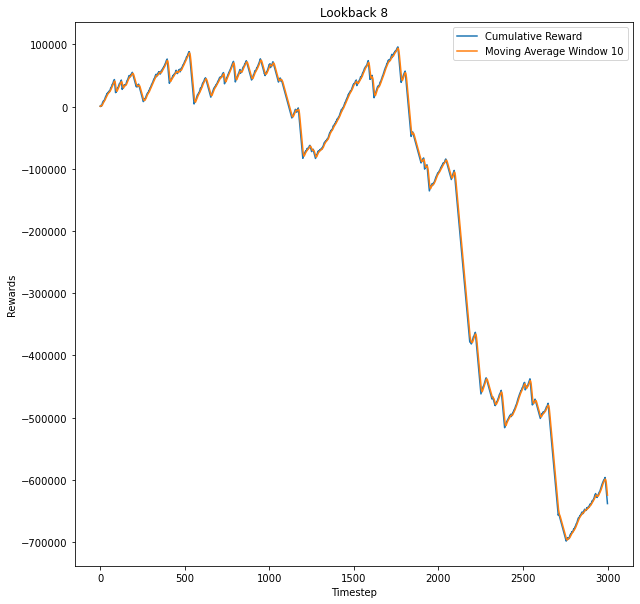

In [32]:
machine1 = Machine_env(tm,r_func)
print(r_func)
baseline = StateValueNetwork(machine1.observation_space)
pol = policy_estimator(machine1)

#Hyper Parameters
timestep = 3000
gamma = 0.9
lr= 0.005
lookback = 8

results = recurrent_pg_baseline(machine1,baseline,pol,timestep,lookback,gamma,lr)
rewards = results[0]
actions = np.array(results[1])
states = results[2]

episode = [i for i in range(len(rewards))]

#Moving average we will use a window size of 50

moving_averages = []
window_size = 10

df = pd.DataFrame(rewards,columns = ['r'])
moving_ave = df.r.rolling(window_size,min_periods=1).mean().values

fig = plt.figure(figsize=(10,10))
plt.plot(episode,rewards,label = 'Cumulative Reward')
plt.plot(episode,moving_ave,label = f'Moving Average Window {window_size}')
plt.title(f'Lookback {lookback}')
plt.xlabel('Timestep')
plt.ylabel('Rewards')
plt.legend()
plt.show()

In [49]:
# machine1 = Machine_env()
# pol = policy_estimator(machine1)
# x = [machine1.sensor(9),machine1.sensor(9)]
# #x = [machine1.sensor(9)]
# x = torch.FloatTensor(x)
# pol(x).detach().numpy()[-1]

# Episodic/Monte Carlo

In [14]:
class Machine_env2():

    def __init__(self,tm,r_func):
        self.action_space = [0,1]
        self.state = 0 #Random initialise the start state, assumes uniform distribution for initial state,random.randrange(10)
        self.state_seq = [] #initialise a list that records the actual states
        self.reward_func = r_func
        self.observation_space = 4
        self.transition  = tm
        self.simulator = Machine() #simulator to generate sensor readings
        self.done = False
        self.steps = 0
    
    def sensor(self,state): # generate observation at state
        self.simulator.curr_state = state
        sensor_reading = self.simulator.readSensors()
        return sensor_reading
    
    def step(self,action): # simulate movement of states given an action
        self.state_seq.append(self.state) #record current state
        
        transition_mat_action = self.transition[action]
        #print(f"Transition Prob: {transition_mat_action[self.state]}")
        nxt_state = np.random.choice([i for i in range(10)],1,p=transition_mat_action[self.state])[0] #select nxt state based
        reward = self.reward_func[nxt_state] #reward for going to next state
        self.state = nxt_state #update state
        
        self.steps += 1
        
        #if(((nxt_state == 0) and (self.steps > 20)) or (self.steps >= 30)):#condition for end of episode
        if self.steps >= 30:   
            self.done = True


        return reward
    
    def reset(self):
        self.state = 0
        self.done = False
        self.steps = 0
        self.state_seq = []
        return 
        

In [16]:
def recurrent_pg_baseline_montecarlo(machine,baseline_net,policy_estimator,episodes,gamma,lr): #Learning algo
    # Set up lists to hold results
    # Set up lists to hold results
    total_rewards = [] #Total actual reward for each episode
    batch_rewards = []  #Discounted expected future rewards for each batch
    batch_actions = []
    batch_observation = []
    state_seq = []

    
    # Define optimizer
    optimizer = torch.optim.Adam(policy_estimator.parameters(),lr=lr)
    state_val_optimizer = torch.optim.Adam(baseline_net.parameters(),lr=0.001)
    
    action_space = machine.action_space
    
    machine.reset()
    observation = []
    rewards = []
    actions = []
    t = 0
    
    for ep in range(episodes):
        machine.reset()
        observation = []
        rewards = []
        actions = []
        
        while(not machine.done):
            obs = machine.sensor(machine.state).tolist() #observation

            observation.append(obs)

            
            action_probs = policy_estimator(observation).detach().numpy()[-1] #convert to numpy and get action prob for the latest

            try:
                action = np.random.choice(action_space, p=action_probs) #select weighted actions based on NN output prob
            except: #in the event converged
                action_probs = np.nan_to_num(action_probs)
                action_probs = np.round(action_probs)
                action = np.random.choice(action_space, p=action_probs)

            print(f"Sensor: {obs}, Action prob: {action_probs}, Action: {action}, state: {machine.state}")

            r = machine.step(action) #receive reward and update machine to the next state after doing the sampled action

            rewards.append(r)
            actions.append(action)

            while(r == -maintenance_cost): #cumulate maintenance
                r = machine.step(0)
                rewards[-1] += r 
                print(f"Maintenance in progress, cumulative {rewards[-1]}")
            
    
        discount_r = normalized_discount_reward(rewards,gamma) #normalised future rewards

        obs_tensor = torch.FloatTensor(observation)
        action_tensor = torch.LongTensor(actions)
        reward_tensor = torch.from_numpy(np.array(discount_r).copy()) #discounted reward G

        #calculate state values 
        state_value_tensor = stack_state_value(np.array(observation),baseline_net)

        #train state value network
#             print(rewards)
#             print(reward_tensor,state_value_tensor)
        train_value(reward_tensor,state_value_tensor,state_val_optimizer)

        #calculate delta or advantage 
        deltas = [gt - val for gt, val in zip(reward_tensor, state_value_tensor)]
        deltas = torch.tensor(deltas)



        logprob = torch.log(policy_estimator(obs_tensor))

        #print(logprob[np.arange(len(action_tensor)), action_tensor])
        selected_logprobs = deltas * logprob[np.arange(len(action_tensor)), action_tensor]
        print(selected_logprobs)


        loss = -selected_logprobs.mean()

        if loss != 0:
            optimizer.zero_grad()
            # Calculate gradients
            loss.backward()
            # Apply gradients
            optimizer.step()

        total_rewards.append(sum(rewards)) #Cumulative reward for this batch
        print(f"Reward for up to this episode {ep} is {total_rewards[-1]}, loss is {loss}")
        continue
            
        total_rewards.append(sum(rewards))
        
        
        
#         #Tensorboard params
#         writer.add_scalar("Loss", loss, ep)
#         writer.add_scalar('Rewards',sum(rewards),ep)
#         for name, weight in policy_estimator.network.named_parameters():
#             try:
#                 writer.add_histogram(name,weight, ep)
#             except:
#                 continue
#             if weight.grad != None:
#                 writer.add_histogram(f"{name}.grad",weight.grad, ep)
    
#     writer.add_graph(policy_estimator.network,torch.FloatTensor(machine.sensor(0))) #draw graph
#     writer.flush()
#     writer.close()
    
    return (total_rewards,batch_actions,state_seq)

C:\Users\overl\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.20.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


{0: 1000, 1: 900, 2: 800, 3: 500, 4: -500, 5: -500, 6: -500, 7: -500, 8: -3000, 9: -1000}
Sensor: [0.3807507762454214, 0.6361738006384455, 0.23620420574119588, 0.24661291254615758], Action prob: [0.50629276 0.49370724], Action: 0, state: 0
Sensor: [0.32693456590855147, 0.584582397752011, 0.22895891251197156, 0.3115032267603916], Action prob: [0.50738144 0.49261862], Action: 0, state: 1
Sensor: [0.3425466971943434, 0.6491868988073065, 0.2233219306026904, 0.2548158056844297], Action prob: [0.5079862  0.49201375], Action: 0, state: 1
Sensor: [0.35519110517563685, 0.6301193747618096, 0.21780008347461696, 0.32515100329823626], Action prob: [0.50839037 0.49160966], Action: 0, state: 1
Sensor: [0.3851757862306747, 0.6720971267367457, 0.17417835183964436, 0.3585998474681449], Action prob: [0.5086722  0.49132782], Action: 1, state: 1
Maintenance in progress, cumulative 500
Sensor: [0.33074796324258576, 0.6746131291027251, 0.21121481641485515, 0.2338107580761701], Action prob: [0.50855947 0.4914

Sensor: [0.4143199968316947, 0.6378643148188968, 0.23246818178442533, 0.27597823619356576], Action prob: [0.5314832  0.46851686], Action: 0, state: 0
Sensor: [0.3468937225333734, 0.5946620221608515, 0.20501278854769298, 0.3005072072462023], Action prob: [0.5175985  0.48240146], Action: 0, state: 1
Sensor: [0.4060190615615732, 0.6674612430892846, 0.2274383467572485, 0.24180418323013306], Action prob: [0.5077171  0.49228293], Action: 1, state: 2
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -100
Sensor: [0.36562575129030167, 0.6328459053230385, 0.2224506825882798, 0.23306430111823728], Action prob: [0.50096774 0.49903226], Action: 1, state: 1
Maintenance in progress, cumulative 500
Sensor: [0.3009224501566571, 0.5912012538222713, 0.21351918336272876, 0.2424913485423944], Action prob: [0.49676666 0.50323343], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
Sensor: [0.3590982537111696, 0.6703716905448572, 0

Sensor: [0.40818910210948167, 0.6834834440561524, 0.2226560644951142, 0.29196394539782694], Action prob: [0.5963282 0.4036719], Action: 0, state: 0
Sensor: [0.36226049068283195, 0.6432136931727878, 0.2219179397720937, 0.2813840450061223], Action prob: [0.5965306 0.4034694], Action: 0, state: 0
Sensor: [0.3853489145033908, 0.6409588553282793, 0.22145856445352766, 0.2749625249996977], Action prob: [0.5967068  0.40329322], Action: 0, state: 1
Sensor: [0.34336968866310585, 0.4961261708458789, 0.1980928689050635, 0.1999737798902981], Action prob: [0.59624815 0.40375182], Action: 0, state: 2
Sensor: [0.34252703118283534, 0.6885090835135537, 0.23550366287251537, 0.2540316053553983], Action prob: [0.59636724 0.40363273], Action: 0, state: 2
Sensor: [0.3666473130910742, 0.613911003052326, 0.2671346222327385, 0.2789642557786186], Action prob: [0.59652585 0.40347418], Action: 0, state: 2
Sensor: [0.33576475349227286, 0.6014134624479789, 0.21557551782341872, 0.25964206697744524], Action prob: [0.5

Sensor: [0.29076997472177846, 0.617589148875139, 0.5314019059289486, 0.2548338947571642], Action prob: [0.5740596  0.42594033], Action: 0, state: 9
Sensor: [0.3324398994716298, 0.39456197334504034, 0.2512250274184526, 0.2643206116506308], Action prob: [0.5739033  0.42609668], Action: 0, state: 9
Sensor: [0.33820632071407764, 0.6368974043012928, 0.5192123134825947, 0.27481102620879244], Action prob: [0.57378143 0.42621854], Action: 1, state: 9
Sensor: [0.34202013820331134, 0.663358210978005, 0.22266971996360613, 0.3323758441093241], Action prob: [0.5743027 0.4256974], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
tensor([-1.2378, -0.6882, -0.2025,  0.2306,  0.6197,  1.5011,  1.2563,  0.5982,
         0.4000,  0.5780,  0.1663, -0.0191, -0.1886, -0.3370, -0.7314, -0.5419],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this episode 9 is -1000, loss is -0.0877314081971096
Sensor: [0.3691273354962358, 0.665191268624

         0.4899,  1.2525], dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this episode 12 is 11800, loss is -0.03438448407320771
Sensor: [0.3736894515206817, 0.5815209009434833, 0.17650797131517731, 0.26666892744190607], Action prob: [0.62644047 0.37355953], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
Sensor: [0.341313537109762, 0.6293313073829944, 0.19118824737926443, 0.2690044283995581], Action prob: [0.64709556 0.3529044 ], Action: 0, state: 0
Sensor: [0.3249083659234877, 0.6355872104611238, 0.21006032766197424, 0.3108605114029881], Action prob: [0.66304016 0.3369598 ], Action: 1, state: 0
Maintenance in progress, cumulative 500
Sensor: [0.3614910022913233, 0.6820621066895192, 0.2382936131033507, 0.21697178795034328], Action prob: [0.674343   0.32565704], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -1500
Maintenance in progress, cumulative -500
Sensor: [0.4161

Sensor: [0.29101059292357007, 0.6468643170760845, 0.2025439886537576, 0.5361845579651053], Action prob: [0.6723377  0.32766232], Action: 0, state: 0
Sensor: [0.3914459156211895, 0.6783547527962592, 0.23035523689876014, 0.3422656728455744], Action prob: [0.6728576 0.3271424], Action: 0, state: 0
Sensor: [0.36620009251588903, 0.6330990193095606, 0.22523441877531097, 0.19157275864778228], Action prob: [0.672239   0.32776096], Action: 1, state: 1
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
tensor([-1.1066, -0.7958, -0.5753, -0.3952, -0.6668, -0.2581, -0.1374, -0.0278,
         0.0337,  0.2503,  0.1175,  0.1891,  0.7144,  0.2820,  0.9556,  0.8738,
         0.3384,  0.3842,  0.4259,  1.2970], dtype=torch.float64,
       grad_fn=<MulBackward0>)
Reward for up to this episode 16 is 11900, loss is -0.09494185601641521
Sensor: [0.2713729126959296, 0.6465099122391287, 0.19223658610713606, 0.2595097497678045], Action prob: [0.6456086  0.35439146], Action: 1, stat

Sensor: [0.34314917937525663, 0.3876513313491103, 0.2312942522006366, 0.18817739508161668], Action prob: [0.7312482 0.2687518], Action: 1, state: 8
Sensor: [0.3203890484260293, 0.38796329966793397, 0.2381185778215536, 0.23289377176601975], Action prob: [0.72935504 0.27064493], Action: 0, state: 8
Sensor: [0.3341990363032813, 0.6013099584695555, 0.5064417065317475, 0.26563427269905837], Action prob: [0.7305773 0.2694227], Action: 0, state: 8
Sensor: [0.3509988811174883, 0.6095800479376932, 0.5030705604601151, 0.20502601287911593], Action prob: [0.73211277 0.26788723], Action: 0, state: 8
Sensor: [0.31604623824495737, 0.34581166179017886, 0.2167755925251923, 0.23390544439246597], Action prob: [0.73021895 0.269781  ], Action: 0, state: 8
Sensor: [0.6100235202168993, 0.6113979689320354, 0.5386982812403742, 0.27091831027069185], Action prob: [0.73349035 0.2665096 ], Action: 0, state: 8
tensor([ 1.3005,  0.4281,  0.4454,  0.4705,  0.4950,  0.5072,  1.7235,  0.3112,
         0.2291,  0.6945, 

Sensor: [0.39162037996650156, 0.5977215019716897, 0.5221748290074739, 0.23631580097253935], Action prob: [0.9362087  0.06379124], Action: 0, state: 8
Sensor: [0.5839975420792688, 0.6003839014264803, 0.24996837499320376, 0.24034369192914348], Action prob: [0.9382782  0.06172174], Action: 0, state: 8
Sensor: [0.5726582086210215, 0.6272642944595161, 0.21233270213383768, 0.22978973349191578], Action prob: [0.939501 0.060499], Action: 0, state: 8
Sensor: [0.5127583654178981, 0.6710011191691007, 0.1980198373895068, 0.25593019899473973], Action prob: [0.94021064 0.05978933], Action: 0, state: 8
Sensor: [0.3658493011328768, 0.6522793747223953, 0.22773748276628417, 0.5823927596825866], Action prob: [0.9404234  0.05957653], Action: 0, state: 8
Sensor: [0.32974896331107295, 0.38308267024584464, 0.20058675690895666, 0.2785559292156283], Action prob: [0.9399162  0.06008388], Action: 0, state: 8
Sensor: [0.4212393703560172, 0.6724964863873838, 0.5349220639512962, 0.25836687387413215], Action prob: [

Sensor: [0.3320799371320771, 0.6487052113694501, 0.20388681925203267, 0.3383518570404088], Action prob: [0.89023983 0.10976016], Action: 0, state: 0
Sensor: [0.33289243891394604, 0.58515119370355, 0.2027539083328076, 0.2704366655036565], Action prob: [0.8898656  0.11013439], Action: 0, state: 0
Sensor: [0.32424271322009385, 0.6432924046851028, 0.21601541534626367, 0.17673273481092427], Action prob: [0.8895953  0.11040468], Action: 0, state: 0
Sensor: [0.33464007891781067, 0.5957963034467486, 0.2309336472951589, 0.264202589851948], Action prob: [0.889438   0.11056205], Action: 0, state: 1
Sensor: [0.36875924729168197, 0.6624060819147952, 0.22793451146665172, 0.26469630313171133], Action prob: [0.8899851  0.11001488], Action: 0, state: 2
Sensor: [0.31561401134465666, 0.6293992329766911, 0.17583361479979118, 0.2232511773741988], Action prob: [0.889636   0.11036403], Action: 1, state: 2
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -100
Sensor: [0.3614047282

       grad_fn=<MulBackward0>)
Reward for up to this episode 26 is 14500, loss is -0.14916197239632872
Sensor: [0.3820756748882991, 0.6384439108474153, 0.1943031133261689, 0.2440945415755722], Action prob: [0.7653447  0.23465529], Action: 1, state: 0
Maintenance in progress, cumulative 500
Sensor: [0.3087787881870861, 0.6625671351548267, 0.22601415077625595, 0.2807160411234586], Action prob: [0.81184316 0.18815681], Action: 0, state: 0
Sensor: [0.36403156575919915, 0.6258123732639228, 0.23378267960083088, 0.24489280266720334], Action prob: [0.83576846 0.16423154], Action: 0, state: 0
Sensor: [0.375405040248648, 0.6589580908849673, 0.19744203289566428, 0.29143253692874055], Action prob: [0.848205   0.15179501], Action: 0, state: 0
Sensor: [0.34554285396731355, 0.6666461023673055, 0.23572123000545162, 0.28347761570566377], Action prob: [0.8548615  0.14513853], Action: 0, state: 0
Sensor: [0.39948752953180333, 0.6355191025281653, 0.1699105248936447, 0.28374036429423044], Action prob: [0.8

Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -1500
Maintenance in progress, cumulative -700
Sensor: [0.3837060078818087, 0.6459595044652209, 0.2056191075839305, 0.24509061784182654], Action prob: [0.8468765  0.15312351], Action: 0, state: 2
Sensor: [0.5960092062775766, 0.6135380121939579, 0.18371535473470557, 0.27154321729815606], Action prob: [0.8485566  0.15144339], Action: 0, state: 9
Sensor: [0.5700061887238266, 0.6171242038443678, 0.22243846026794195, 0.2806820951130296], Action prob: [0.8494334  0.15056653], Action: 1, state: 9
Sensor: [0.5525177664910035, 0.3707814694319105, 0.21397923272340522, 0.23537315519231955], Action prob: [0.8475643  0.15243569], Action: 0, state: 9
Sensor: [0.36872944771751665, 0.3453284587826523, 0.2574511348926142, 0.21318332306600635], Action prob: [0.8441537  0.15584628], Action: 0, state: 9
Sensor: [0.6050988463493133, 0.6374666090439913, 0.23007883198597132, 0.24333552937015007], Action prob: [0.8468968  0.15310316

Sensor: [0.37101810437821514, 0.5718571463240135, 0.2464754500409251, 0.30136025047311293], Action prob: [0.8203186  0.17968145], Action: 0, state: 1
Sensor: [0.36346012611212364, 0.6170047626355717, 0.21149619821462942, 0.2667463690860153], Action prob: [0.8202805  0.17971954], Action: 1, state: 1
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
tensor([-0.7437, -0.4899, -0.3386, -0.2394, -0.1570, -0.0934, -0.0369, -0.0343,
        -0.0166,  0.0248,  0.0475,  0.0705,  0.2754,  0.0659,  0.0928,  0.1177,
         0.1401,  1.3574,  0.1445,  0.1592,  0.1715,  1.5941,  0.1891,  1.7293],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this episode 31 is 14100, loss is -0.16792311157296166
Sensor: [0.3527377247489736, 0.5884201364441674, 0.19254803770480866, 0.29596899379249486], Action prob: [0.7650605  0.23493952], Action: 0, state: 0
Sensor: [0.3793577907262014, 0.6417361624592555, 0.19856312895474634, 0.25149849792060375], Action prob: 

Sensor: [0.3831010534639546, 0.7092611312921825, 0.21031876960976117, 0.2240677832332057], Action prob: [0.82090473 0.17909528], Action: 0, state: 1
Sensor: [0.3851080813001763, 0.634400853634163, 0.24747406728897972, 0.27829315553846445], Action prob: [0.82150126 0.17849879], Action: 0, state: 2
Sensor: [0.3397772050842915, 0.6365500996120843, 0.28350291460219573, 0.2596483988526817], Action prob: [0.82138515 0.17861478], Action: 0, state: 2
Sensor: [0.40578725096279067, 0.39267455579204474, 0.1898127541173126, 0.22863922471588147], Action prob: [0.81873757 0.18126248], Action: 0, state: 3
Sensor: [0.3937196499093076, 0.3757906518316693, 0.18438903468806406, 0.26714466384259833], Action prob: [0.81683403 0.18316597], Action: 0, state: 3
Sensor: [0.39690491954492024, 0.6372842183685451, 0.2669301609583408, 0.2667524621080595], Action prob: [0.8192631  0.18073684], Action: 1, state: 3
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -200
Sensor: [0.419140329

Sensor: [0.3433146945223128, 0.6678319868630834, 0.22727339266404456, 0.29165308807496193], Action prob: [0.78410107 0.21589896], Action: 0, state: 2
Sensor: [0.40470790824836933, 0.6478948135571214, 0.20251849076880224, 0.22716075846185071], Action prob: [0.7841356  0.21586439], Action: 0, state: 3
Sensor: [0.3546195737018961, 0.6030722255255423, 0.4962931964330509, 0.48612785895159605], Action prob: [0.78524125 0.21475881], Action: 0, state: 8
Sensor: [0.38174780139655123, 0.34820976406100096, 0.2014880075974003, 0.22739329835569436], Action prob: [0.7815322  0.21846782], Action: 0, state: 8
Sensor: [0.5400703576533582, 0.6491242939939429, 0.2068879722634723, 0.21715349986383994], Action prob: [0.7836141  0.21638587], Action: 0, state: 8
Sensor: [0.5663307951700167, 0.6679370149361681, 0.21624932320892748, 0.1955824425518224], Action prob: [0.78515184 0.21484813], Action: 0, state: 8
Sensor: [0.40987653756994175, 0.4161112159349601, 0.2464894003200481, 0.5019030576036972], Action pro

       grad_fn=<MulBackward0>)
Reward for up to this episode 39 is 12200, loss is -0.0784407108394156
Sensor: [0.3644325426127512, 0.6150329846539717, 0.25232798433315884, 0.209728593896937], Action prob: [0.73600227 0.26399776], Action: 0, state: 0
Sensor: [0.3594080016922543, 0.6178204231665668, 0.22938966573223613, 0.24120092347687144], Action prob: [0.75846815 0.24153179], Action: 0, state: 1
Sensor: [0.3469809181891826, 0.6431591423147177, 0.25468702991282083, 0.25569269419607976], Action prob: [0.76384497 0.23615503], Action: 0, state: 1
Sensor: [0.33227942812197003, 0.5911937252420898, 0.20998776290856597, 0.24557560842928486], Action prob: [0.7631296  0.23687042], Action: 0, state: 2
Sensor: [0.4186707561737896, 0.6372561634500504, 0.21317864261828443, 0.26598205841320394], Action prob: [0.76346165 0.23653832], Action: 0, state: 2
Sensor: [0.37527760074705757, 0.6658629232156257, 0.22714025440784977, 0.18154265167958394], Action prob: [0.7635467  0.23645331], Action: 0, state: 

Sensor: [0.3680142771762628, 0.689376632485556, 0.1932164965677389, 0.21435191739126278], Action prob: [0.77717656 0.22282347], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
Sensor: [0.38542850764743164, 0.6503171137757368, 0.23179635262658643, 0.2920618761608633], Action prob: [0.7776772  0.22232276], Action: 0, state: 0
Sensor: [0.32691913116827115, 0.5897644835398718, 0.1887725015254054, 0.22271103241747586], Action prob: [0.77672696 0.22327295], Action: 0, state: 0
Sensor: [0.41342584558117235, 0.6089701444543245, 0.24692409041803232, 0.2775550910750281], Action prob: [0.77747834 0.22252168], Action: 0, state: 1
Sensor: [0.35801745556622655, 0.6279568040985127, 0.24550620521637506, 0.2095576919844211], Action prob: [0.7775305  0.22246951], Action: 1, state: 1
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
Sensor: [0.37116851380149257, 0.6138000838761279, 0.2055104040052327, 0.20069244670846553], 

Sensor: [0.3557180898473924, 0.4374823210315828, 0.20420191117048658, 0.24870969269767923], Action prob: [0.770822   0.22917803], Action: 0, state: 0
Sensor: [0.3682085951262185, 0.6661670848535376, 0.19885576209611067, 0.24063210858302814], Action prob: [0.8054995  0.19450046], Action: 0, state: 0
Sensor: [0.3487696662767721, 0.6257003919179982, 0.2440352002330045, 0.2652264308331317], Action prob: [0.8167296 0.1832704], Action: 0, state: 0
Sensor: [0.4062011955226992, 0.6132053860357904, 0.2201587719487101, 0.22530179525558922], Action prob: [0.8204237 0.1795763], Action: 0, state: 1
Sensor: [0.42338739374979345, 0.6454952193238245, 0.22317433839867862, 0.2608464624116148], Action prob: [0.82245946 0.17754056], Action: 0, state: 1
Sensor: [0.31932109712216855, 0.6802769340239481, 0.21926348857727884, 0.23556681883037156], Action prob: [0.82309264 0.17690738], Action: 0, state: 2
Sensor: [0.3272406100070761, 0.5705911513085938, 0.25429258325230947, 0.27663105321846493], Action prob: [

        -0.0550, -0.0813], dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this episode 47 is -14000, loss is 0.027875666148012825
Sensor: [0.34161818138327565, 0.5627626133604303, 0.21949657719930393, 0.23796330473872385], Action prob: [0.811738 0.188262], Action: 0, state: 0
Sensor: [0.394922292418619, 0.6276134770075382, 0.17626875564718475, 0.28599792749838093], Action prob: [0.8514627  0.14853726], Action: 0, state: 1
Sensor: [0.3549217780219629, 0.6228174356420756, 0.21728592180295556, 0.2538675131845164], Action prob: [0.86335516 0.13664487], Action: 1, state: 1
Maintenance in progress, cumulative 500
Sensor: [0.3888578521041306, 0.6587554405038838, 0.18630724646106697, 0.28266339989798556], Action prob: [0.867759   0.13224103], Action: 0, state: 0
Sensor: [0.41078971409693643, 0.6422984304367931, 0.18507420045969997, 0.283131642185088], Action prob: [0.86964107 0.13035892], Action: 0, state: 0
Sensor: [0.3343603382855678, 0.6167776627320194, 0.18075392020385564, 0

Sensor: [0.3542408859513606, 0.6547149447664978, 0.21374196983848587, 0.2331819763490518], Action prob: [0.8733281  0.12667195], Action: 0, state: 1
Sensor: [0.37495558550269004, 0.589464322088915, 0.23082857449750002, 0.20835067572933846], Action prob: [0.8727403  0.12725972], Action: 0, state: 1
Sensor: [0.371537258175097, 0.6425567446994318, 0.23442183585639617, 0.2509285693666913], Action prob: [0.8731439  0.12685606], Action: 0, state: 1
Sensor: [0.34157867917940193, 0.6334025167902604, 0.23048787676731322, 0.23663925516221526], Action prob: [0.8730408  0.12695922], Action: 0, state: 2
Sensor: [0.3531678731436259, 0.688389948074102, 0.22276029413967258, 0.2092791893181744], Action prob: [0.8735259  0.12647408], Action: 1, state: 2
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -100
Sensor: [0.4140181778710922, 0.6125618410561952, 0.20237239008381075, 0.2097639236844673], Action prob: [0.87312937 0.12687057], Action: 0, state: 1
Sensor: [0.36811848049

Sensor: [0.3416630628767485, 0.6767489683798199, 0.20968727528604394, 0.2869454452482636], Action prob: [0.84870267 0.15129733], Action: 1, state: 2
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -1500
Maintenance in progress, cumulative -600
tensor([ 0.0621,  0.1245,  0.1747,  0.2240,  0.2507,  0.2770,  0.3022,  0.1763,
         0.0688, -0.0342, -0.1225, -2.3929, -0.1794, -0.1595, -0.1418, -0.1263,
        -1.2737, -1.4511, -0.1188, -0.1085, -0.1010, -1.0678],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this episode 52 is -4900, loss is 0.2553238424822127
Sensor: [0.3766060538367276, 0.6332404179511367, 0.20087494314394108, 0.24805005207486283], Action prob: [0.7935757  0.20642433], Action: 0, state: 0
Sensor: [0.37679927632905064, 0.6505217387869484, 0.183343105978927, 0.26194745816104376], Action prob: [0.81702644 0.18297356], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -150

Reward for up to this episode 55 is 8700, loss is -0.007540622820540273
Sensor: [0.35736438845881136, 0.6022909804342116, 0.21315226970158502, 0.29035408680924735], Action prob: [0.75936955 0.24063051], Action: 0, state: 0
Sensor: [0.40748476821407265, 0.6429051033763878, 0.18805979144879453, 0.27845374253718885], Action prob: [0.7581642  0.24183582], Action: 0, state: 0
Sensor: [0.3452167058813258, 0.6574578032645497, 0.23042188944732667, 0.30452908248787025], Action prob: [0.7456666 0.2543334], Action: 0, state: 0
Sensor: [0.4463949249581446, 0.5791911185497827, 0.19608761781590073, 0.2640770298241236], Action prob: [0.73442537 0.2655746 ], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
Sensor: [0.3159428864730566, 0.6526030309025839, 0.24968601519388206, 0.2514657489830052], Action prob: [0.72834533 0.27165464], Action: 0, state: 0
Sensor: [0.37997039760789264, 0.6403155397325214, 0.23801737628106492, 0.21242445391495526], Action 

Sensor: [0.32913601512921414, 0.6187756279095318, 0.1797865685482261, 0.22315428935111098], Action prob: [0.80360067 0.19639938], Action: 1, state: 1
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -1500
Maintenance in progress, cumulative -500
Sensor: [0.34147602112621805, 0.5956762908227184, 0.1472840384231757, 0.2579617411177923], Action prob: [0.8019859  0.19801413], Action: 0, state: 0
Sensor: [0.31861299146955036, 0.598697991784968, 0.20350565589913894, 0.2663271908443116], Action prob: [0.8015923  0.19840768], Action: 0, state: 0
Sensor: [0.33886045244532376, 0.6541190391201571, 0.19449956014493494, 0.21191146807845057], Action prob: [0.8022372  0.19776274], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -1500
Maintenance in progress, cumulative -500
Sensor: [0.36605424808129455, 0.6349366428292116, 0.18818337386950523, 0.2386128172871667], Action prob: [0.8023255  0.19767453], Action: 1, state: 0
M

Sensor: [0.39788590477441715, 0.6677434307934151, 0.2006074833021505, 0.2797864124137231], Action prob: [0.8103248 0.1896752], Action: 0, state: 1
Sensor: [0.3577422846434253, 0.6210519129323235, 0.24181200709082484, 0.2700585357119148], Action prob: [0.80996567 0.19003429], Action: 0, state: 1
Sensor: [0.3300536436725118, 0.6158363144433604, 0.2084935987741786, 0.20278083818497397], Action prob: [0.8091985  0.19080153], Action: 0, state: 1
Sensor: [0.30438736476888606, 0.6434493907096344, 0.22994318634330627, 0.22045543075900928], Action prob: [0.80929756 0.19070242], Action: 1, state: 2
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -1500
Maintenance in progress, cumulative -600
tensor([-0.4987, -2.6161, -0.3389, -0.2566, -1.4338, -0.1912, -0.1297, -0.0744,
        -0.0243,  0.1615,  0.1618,  0.0404,  0.0769,  0.1101,  0.1395,  0.1666,
         0.1916,  0.2097,  0.2256,  0.2417,  0.2569,  2.0989],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Rewa

Sensor: [0.31438461399627493, 0.6603547493993465, 0.25413738147301485, 0.577656944263101], Action prob: [0.7914692  0.20853075], Action: 0, state: 8
Sensor: [0.3831121344849797, 0.42766161325449537, 0.1795326875734319, 0.15936833898700853], Action prob: [0.7891909  0.21080914], Action: 0, state: 8
Sensor: [0.33243386950473613, 0.39169440118349064, 0.22374589552249663, 0.2103544838766405], Action prob: [0.7877792  0.21222074], Action: 0, state: 8
Sensor: [0.5461128841764619, 0.4104702929080239, 0.22312956635523204, 0.2541803975146999], Action prob: [0.78914535 0.21085462], Action: 1, state: 8
Sensor: [0.5620533952416807, 0.6268041473014736, 0.195533465070464, 0.2268726320514574], Action prob: [0.7918589  0.20814112], Action: 1, state: 8
Sensor: [0.571302178563915, 0.6595689977825839, 0.22555770082677712, 0.2363885608651795], Action prob: [0.7932248  0.20677514], Action: 0, state: 8
Sensor: [0.34233162886607016, 0.3764421017879278, 0.22743825901107928, 0.20455720912452008], Action prob: 

Sensor: [0.32741859372243165, 0.5982198834565983, 0.20528508247496552, 0.24112676911362368], Action prob: [0.7626583  0.23734172], Action: 0, state: 2
Sensor: [0.30862083228703063, 0.6631113290549057, 0.20248275051045705, 0.28322509982821087], Action prob: [0.76326686 0.2367332 ], Action: 0, state: 2
Sensor: [0.38334131082951006, 0.701209541205786, 0.24820716316623992, 0.2519004704870561], Action prob: [0.76426226 0.23573773], Action: 0, state: 3
tensor([-0.6039, -2.3467, -0.4287, -1.6286, -0.2429, -0.1499, -0.0650,  0.0630,
        -0.1034, -0.0344,  0.0279,  0.4495,  0.1095,  0.1552,  0.1949,  0.2318,
         0.2608,  0.2882,  0.3115,  0.3298,  0.3386], dtype=torch.float64,
       grad_fn=<MulBackward0>)
Reward for up to this episode 66 is 11100, loss is 0.13535958800721923
Sensor: [0.4153578320976316, 0.6367040451127172, 0.2051949084564477, 0.2356237590280703], Action prob: [0.74632114 0.25367883], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progres

Sensor: [0.3642175590426351, 0.5723021155219115, 0.23519531934140503, 0.3032202514381717], Action prob: [0.69864565 0.3013544 ], Action: 0, state: 1
Sensor: [0.32632232852166404, 0.6249554936154704, 0.20083071336320724, 0.25479600006238085], Action prob: [0.6987501  0.30124992], Action: 0, state: 1
Sensor: [0.38022374925778346, 0.6288008946661894, 0.21962199639740249, 0.24298041996560557], Action prob: [0.69893646 0.30106357], Action: 1, state: 1
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
tensor([-0.6623, -1.8759, -0.5979, -0.4566, -0.3239, -0.2003, -0.0879,  0.0134,
         0.0959,  0.1693,  0.2363,  0.9913,  0.1770,  0.2303,  0.2740,  0.3128,
         0.3492,  0.3808,  1.3707], dtype=torch.float64,
       grad_fn=<MulBackward0>)
Reward for up to this episode 69 is 12600, loss is -0.020857972866864187
Sensor: [0.3930165332839626, 0.649021896024384, 0.25024942284894186, 0.2313915920567735], Action prob: [0.7138575 0.2861425], Action: 0, state: 0
Se

Sensor: [0.40549815824461577, 0.6572929497962474, 0.19584152940684268, 0.5469018024072145], Action prob: [0.6923079  0.30769214], Action: 0, state: 8
Sensor: [0.5392292728944553, 0.6638170468249128, 0.2374391329857707, 0.22866123935838575], Action prob: [0.69196755 0.30803245], Action: 1, state: 8
Sensor: [0.3830657778947485, 0.39898886734252215, 0.17752135749184753, 0.24466024402338435], Action prob: [0.68866545 0.31133455], Action: 0, state: 8
Sensor: [0.549387564232531, 0.624287238201289, 0.19452788785999692, 0.19304499847955997], Action prob: [0.6906272  0.30937275], Action: 0, state: 8
Sensor: [0.3554123626188432, 0.4368612711372179, 0.23067395217327505, 0.5612697666102865], Action prob: [0.69009924 0.30990082], Action: 1, state: 8
Sensor: [0.3571018219584762, 0.6892901836575047, 0.19161449533898045, 0.24090976685604423], Action prob: [0.6916108  0.30838916], Action: 1, state: 0
Maintenance in progress, cumulative 500
Sensor: [0.3913111525467737, 0.6548020279181477, 0.189989279121

       grad_fn=<MulBackward0>)
Reward for up to this episode 75 is -10800, loss is 0.013204431657968942
Sensor: [0.27809169485373086, 0.6682251019804973, 0.2162594418520951, 0.23646657136696045], Action prob: [0.6944452  0.30555487], Action: 0, state: 0
Sensor: [0.359201843229048, 0.622988954307974, 0.25126958512878056, 0.28591156847447685], Action prob: [0.689889 0.310111], Action: 0, state: 0
Sensor: [0.3707493054218131, 0.6341169638186237, 0.22344683690395298, 0.20365078916196017], Action prob: [0.6850653  0.31493464], Action: 0, state: 0
Sensor: [0.33360220076001457, 0.6283514957163369, 0.2073194979079903, 0.2957853134296847], Action prob: [0.6829637  0.31703624], Action: 0, state: 0
Sensor: [0.34011676329238427, 0.6572915715606735, 0.28172121669185624, 0.24415237437773096], Action prob: [0.6822123  0.31778774], Action: 0, state: 0
Sensor: [0.31219583776805243, 0.6790957012764867, 0.1830079604177808, 0.23436567288798282], Action prob: [0.6822161  0.31778386], Action: 0, state: 0
Se

Sensor: [0.3306545921113122, 0.5966586592417275, 0.20135768172937768, 0.2791643252523749], Action prob: [0.6975577 0.3024423], Action: 0, state: 2
tensor([-1.9365, -1.4579, -0.4290, -0.2078, -0.0267,  0.1186,  0.2479,  1.2150,
         0.2873,  0.3810,  0.4346,  0.4890,  0.5261,  0.5723,  0.3602,  0.1648,
        -0.0056, -0.1592, -0.2998, -1.4028, -0.3844, -0.3506, -0.3239, -0.3018],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this episode 78 is -6800, loss is 0.10371539487337683
Sensor: [0.39112280045426284, 0.63338971046805, 0.22194095712978076, 0.2472038720870531], Action prob: [0.7023276  0.29767242], Action: 1, state: 0
Maintenance in progress, cumulative 500
Sensor: [0.35053938982483945, 0.6050808169824466, 0.22913159876299277, 0.24798382219988818], Action prob: [0.700963   0.29903698], Action: 0, state: 0
Sensor: [0.43852242696016885, 0.5177948398729131, 0.24105839105562038, 0.27892035021187483], Action prob: [0.69753027 0.3024697 ], Action: 1, state: 1

Sensor: [0.40163077112342116, 0.6220437613825229, 0.22898942563925642, 0.24488248013674735], Action prob: [0.69057465 0.3094253 ], Action: 1, state: 2
Maintenance in progress, cumulative 400
Sensor: [0.3460909338377579, 0.6807337696006789, 0.17964253550414955, 0.26650334290224326], Action prob: [0.6910536  0.30894637], Action: 0, state: 1
Sensor: [0.36545670438655636, 0.6773504848331453, 0.2508990557130242, 0.21771244150069968], Action prob: [0.69097817 0.30902186], Action: 0, state: 1
Sensor: [0.362950211777546, 0.6879645127915561, 0.2182597831784266, 0.24761992223873572], Action prob: [0.6911187  0.30888134], Action: 0, state: 1
Sensor: [0.39550149876182106, 0.6224346409998087, 0.2007484734072881, 0.258313372736401], Action prob: [0.6906996  0.30930042], Action: 0, state: 1
Sensor: [0.3247303430227799, 0.6965403872488893, 0.1946658721934238, 0.26439666770035586], Action prob: [0.69114155 0.30885845], Action: 1, state: 1
Maintenance in progress, cumulative -1000
Maintenance in progres

Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
Sensor: [0.3348104112156976, 0.6479985279312582, 0.252115377442242, 0.325319261311641], Action prob: [0.7064785  0.29352158], Action: 0, state: 0
Sensor: [0.34018044681259973, 0.6555189363792914, 0.2317551198965629, 0.22044540820652742], Action prob: [0.7066111  0.29338887], Action: 0, state: 1
Sensor: [0.288887083903732, 0.6876595903659858, 0.24365649939605907, 0.2520282493372438], Action prob: [0.70690596 0.293094  ], Action: 0, state: 1
Sensor: [0.3639292123865444, 0.6391441126522237, 0.21950697308842268, 0.2457940541534482], Action prob: [0.7067455  0.29325458], Action: 0, state: 2
Sensor: [0.3165953502345007, 0.6106046661556235, 0.5164962071008737, 0.282343625532841], Action prob: [0.7055247  0.29447535], Action: 0, state: 2
Sensor: [0.3562116214551747, 0.6063667161887163, 0.17856068403294792, 0.20745878819407254], Action prob: [0.70597416 0.29402584], Action: 0, state: 2
Sensor: [0.430476997800012, 0.

       grad_fn=<MulBackward0>)
Reward for up to this episode 85 is -9000, loss is -0.14195848258573768
Sensor: [0.34374133668637824, 0.6095836386101614, 0.20211720269794686, 0.2816986393127391], Action prob: [0.7306391  0.26936093], Action: 0, state: 0
Sensor: [0.37011936227919423, 0.6664935937724271, 0.20030898667761463, 0.24136469031141772], Action prob: [0.7380219  0.26197806], Action: 0, state: 1
Sensor: [0.358485217248969, 0.6571019104155378, 0.1956232555232163, 0.24399338218803557], Action prob: [0.7382282  0.26177177], Action: 1, state: 1
Maintenance in progress, cumulative 500
Sensor: [0.37291005402799793, 0.6412735654692063, 0.23061003190567675, 0.2758459004418702], Action prob: [0.73799133 0.2620087 ], Action: 0, state: 0
Sensor: [0.3579919527814849, 0.6520740535958441, 0.2519475364256423, 0.3251440653557961], Action prob: [0.7381758 0.2618242], Action: 0, state: 1
Sensor: [0.3702935851385793, 0.6615551614522823, 0.22542582403288702, 0.22622347858588487], Action prob: [0.7383

Sensor: [0.43202972433895453, 0.6711979888314861, 0.19694956401625646, 0.2615106912119463], Action prob: [0.75994825 0.24005178], Action: 1, state: 0
Maintenance in progress, cumulative 500
Sensor: [0.3555411089658171, 0.5977123368765864, 0.22859542221884824, 0.3217337319692538], Action prob: [0.7592013  0.24079874], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative 0
Sensor: [0.3588540402492856, 0.5815930103415351, 0.27369828756789133, 0.2758445797542874], Action prob: [0.7586362  0.24136382], Action: 1, state: 0
Maintenance in progress, cumulative 500
Sensor: [0.4054041025184589, 0.6252434775492774, 0.19966646258739768, 0.2677450015310554], Action prob: [0.7591991  0.24080089], Action: 0, state: 0
Sensor: [0.39403727843418546, 0.7048990355772334, 0.22279830050384128, 0.24430337733621413], Action prob: [0.75994503 0.24005492], Action: 1, state: 0
Maintenance in progress, cumulative -1000
Maintenance in progress, cumulative -1500
Maintena

Sensor: [0.3295196121351534, 0.6447910415404269, 0.22343705742567696, 0.26598346958323865], Action prob: [0.8012115  0.19878852], Action: 1, state: 1
Maintenance in progress, cumulative 500
Sensor: [0.3698683477934402, 0.6400731884822998, 0.18966913228448062, 0.2542245888643138], Action prob: [0.8013516  0.19864841], Action: 0, state: 0
Sensor: [0.3858624545324127, 0.6822366390275777, 0.25206022533099837, 0.22675266592631915], Action prob: [0.80155915 0.1984409 ], Action: 0, state: 0
Sensor: [0.3032875243566511, 0.6827793863341977, 0.2024419505199404, 0.22756014132160957], Action prob: [0.80157995 0.19842009], Action: 1, state: 0
Maintenance in progress, cumulative 500
tensor([-0.6087, -0.4578, -0.3560, -0.2712, -0.2019, -0.1407, -0.0861, -0.0372,
         0.0508,  0.2131,  0.0291,  0.0651,  0.7084,  0.1118,  0.1370,  1.1739,
         0.1606,  0.1805,  0.1952,  1.5257,  0.2162,  0.2280,  1.7500],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this episode 90 is 18

Sensor: [0.30762069304326584, 0.6587530123644837, 0.24893821479050837, 0.2045403062603821], Action prob: [0.8580667  0.14193335], Action: 0, state: 0
Sensor: [0.38447527579174917, 0.6301387414022306, 0.22794832910398002, 0.2495574704398921], Action prob: [0.85813993 0.14186005], Action: 0, state: 1
tensor([ 0.2224,  0.2202,  0.2326,  0.2467,  0.2515,  0.2623,  0.2173,  0.1677,
         0.1265,  0.0941,  0.0631,  0.0314,  0.0057, -0.0174, -0.0380, -0.0590,
        -0.0755, -1.1574, -0.1034, -0.1186, -0.1312, -1.7600, -0.1467, -0.1531,
        -0.1656, -2.1592, -0.1677, -0.1656, -0.1640, -0.1624],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this episode 92 is -51700, loss is 0.1534449884965099
Sensor: [0.3738285549463565, 0.6103377324599772, 0.19163110553503604, 0.2600250283760555], Action prob: [0.8354527 0.1645473], Action: 0, state: 0
Sensor: [0.3220475877267971, 0.6222582907682896, 0.20186345618722312, 0.26733764833501134], Action prob: [0.856693   0.14330691

Sensor: [0.3928910525567228, 0.5254551473490164, 0.23172302102493875, 0.2667145309517077], Action prob: [0.8461846  0.15381534], Action: 0, state: 0
Sensor: [0.35224917859552773, 0.6228855603683364, 0.21484863062327256, 0.21781832659278763], Action prob: [0.86742693 0.13257311], Action: 0, state: 0
Sensor: [0.354972542899565, 0.7041633595715437, 0.23400889650771736, 0.3256293441357046], Action prob: [0.8739945  0.12600553], Action: 0, state: 0
Sensor: [0.3350433382950865, 0.6002411082092494, 0.21215994271842892, 0.2876629541660761], Action prob: [0.87518096 0.12481898], Action: 0, state: 1
Sensor: [0.4102448664127071, 0.6342054226482564, 0.23394690239890586, 0.321681761063533], Action prob: [0.87660635 0.12339363], Action: 0, state: 1
Sensor: [0.33321312583345064, 0.6305481045376302, 0.20697115108225547, 0.2725601290684451], Action prob: [0.8769411  0.12305894], Action: 0, state: 1
Sensor: [0.36050438540070073, 0.6472436830079736, 0.21736301528308613, 0.2807803149979509], Action prob: 

Sensor: [0.6041795956934813, 0.6173752824533032, 0.19748371346075883, 0.24056477012859026], Action prob: [0.8845119  0.11548807], Action: 0, state: 8
Sensor: [0.30638029596987393, 0.3161389586511436, 0.23607334599539231, 0.5427897075359924], Action prob: [0.8824942  0.11750576], Action: 1, state: 8
Sensor: [0.32565232119070714, 0.6418130560245642, 0.2148215939951445, 0.5793330746270106], Action prob: [0.8856318  0.11436816], Action: 0, state: 8
Sensor: [0.4148667601446998, 0.6645283023848765, 0.23294953372830107, 0.5847534544744533], Action prob: [0.8870525 0.1129475], Action: 0, state: 8
Sensor: [0.29750594113556045, 0.6444232652120719, 0.5434481956930326, 0.26348460935439383], Action prob: [0.88520265 0.11479733], Action: 0, state: 8
tensor([-4.2184e-01, -2.8728e-01, -2.1653e-01, -1.6106e-01, -1.1337e-01,
        -7.1767e-02, -3.4481e-02, -5.9903e-04,  2.9728e-02,  5.6880e-02,
         7.9286e-02,  9.7948e-02,  1.1289e-01,  1.2747e-01,  1.3379e-01,
         1.4135e-01,  1.4870e-01,  

tensor([-0.3778, -0.2459, -0.1791, -0.1252, -0.0794, -0.0386, -0.1340, -0.0223,
         0.0837,  0.0168,  0.0402,  0.0593,  1.6746,  0.0846,  0.1007,  0.1139,
         0.1234,  0.1283,  0.0980,  0.0730,  1.0069,  0.0255,  0.0814, -0.0131,
        -0.0294], dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for up to this episode 98 is -10700, loss is -0.09861426664430097
Sensor: [0.3340318142972817, 0.6676029820204552, 0.24542110684020496, 0.2802443353742981], Action prob: [0.8811051  0.11889492], Action: 0, state: 0
Sensor: [0.29350617942703217, 0.704213180329003, 0.2315022037502746, 0.26812232412141723], Action prob: [0.9028266  0.09717341], Action: 1, state: 0
Maintenance in progress, cumulative 500
Sensor: [0.31043731755951276, 0.611882829492875, 0.24349171960845148, 0.202885647934776], Action prob: [0.9067341  0.09326587], Action: 0, state: 0
Sensor: [0.3594778651817597, 0.6469142529941446, 0.250255110636676, 0.228077163905677], Action prob: [0.9089224  0.09107762], Action: 0, s

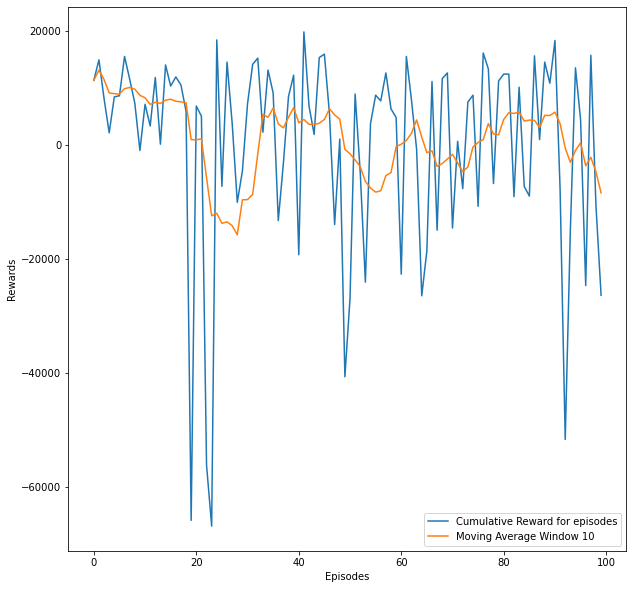

In [28]:
machine2 = Machine_env2(tm,r_func)
print(r_func)
baseline = StateValueNetwork(machine2.observation_space)
pol2 = policy_estimator(machine2)

#Hyper Parameters
episodes = 100
gamma = 0.90
lr= 0.01


results = recurrent_pg_baseline_montecarlo(machine2,baseline,pol2,episodes,gamma,lr)
rewards = results[0]
actions = np.array(results[1])
states = results[2]

episode = [i for i in range(len(rewards))]

#Moving average we will use a window size of 50

moving_averages = []
window_size = 10

df = pd.DataFrame(rewards,columns = ['r'])
moving_ave = df.r.rolling(window_size,min_periods=1).mean().values

fig = plt.figure(figsize=(10,10))
plt.plot(episode,rewards,label = 'Cumulative Reward for episodes')
plt.plot(episode,moving_ave,label = f'Moving Average Window {window_size}')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.show()

# CNN + LSTM

In [52]:
class policy_estimator_cnn(nn.Module): #neural network
    def __init__(self, env):
        super(policy_estimator, self).__init__()
        
        self.conv1 = nn.Conv1d()
        self.lstm = nn.LSTMCell(env.observation_space,128)
        self.layer1 = nn.Linear(128,128)
        
        self.layer2 = nn.Linear(128,len(env.action_space))
       
            
    
    def forward(self, x):#prediction is raw value
        x = torch.FloatTensor(x)
        output = []
        hx = torch.zeros(1,128)
        cx = torch.zeros(1,128)
        
        if(len(x.size()) == 1): #single tensor ie. [x1,x2,x3,x4]
            x = x.unsqueeze(0)
            #print(x)
            hx, cx = self.lstm(x, (hx, cx))
            output = hx
            #print(output)

        elif(len(x.size()) == 2): #2 dimension
            x = x.unsqueeze(1) #dim = (timestep,batch,features), note batch = 1
#             print(x.size())
            for i in range(x.size()[0]): #loop to simulate recurrent network
                #print(y)
                hx, cx = self.lstm(x[i], (hx, cx))
                output.append(hx)
        
            output = torch.stack(output, dim=0).squeeze(1) #convert to tensor
        
        x = F.leaky_relu(output)
        x = self.layer1(x)
        x  = F.relu(x)
        x = self.layer2(x)

        return F.softmax(x,dim = -1)



(1, 5, 14)
torch.Size([1, 10, 5])


In [208]:
import numpy
import torch

X = np.array([[2.1,2.3,5.3,6.4],[2.3,4.3,1.3,8.4],[1.1,9.3,5.3,0.4]])
# Y = np.random.randint(0, 9, 10).reshape(1, 1, -1)

class Simple1DCNN(torch.nn.Module):
    def __init__(self):
        super(Simple1DCNN, self).__init__()
        self.layer1 = torch.nn.Conv1d(in_channels=1, out_channels=20, kernel_size=3, stride=1,padding = "SAME")
        self.act1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Conv1d(in_channels=20, out_channels=1, kernel_size=1,padding = 1)
        self.lstm = nn.LSTMCell(6,10)
        self.act2 = torch.nn.ReLU()
        self.layer3 = nn.Linear(10,2)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        
        x = self.layer1(x)
        print("First layer",x.shape)
        x = self.act1(x)
        
        x = self.layer2(x)

        print("CNN out", x.shape)
        output = []
        hx = torch.zeros(x.shape[1],10)
        cx = torch.zeros(x.shape[1],10)
        
        for i in range(x.size()[0]):
            hx, cx = self.lstm(x[i], (hx, cx))
            output.append(hx)
            
        output = torch.stack(output, dim=0).squeeze(1) #convert to tensor
        print(output,output.shape)
#         output = torch.reshape(output,(3,1,20))
#         print(output)
        
        x = self.layer3(output)
        print(x)
        log_probs = torch.nn.functional.softmax(x, dim=-1)

        return log_probs
print(X.shape, X)
model = Simple1DCNN()
y = model(torch.FloatTensor(X))
print(y.shape)
print(y)

(3, 4) [[2.1 2.3 5.3 6.4]
 [2.3 4.3 1.3 8.4]
 [1.1 9.3 5.3 0.4]]


TypeError: conv1d(): argument 'padding' (position 5) must be tuple of ints, not str